In [45]:
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
from astropy.io import ascii
%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
plt.rcParams["figure.figsize"] = (10,7.5)
plt.rcParams.update({'font.size': 20})
label_size = 15
plt.rcParams['xtick.labelsize'] = 15#label_size
plt.rcParams['ytick.labelsize'] =15 #label_size

# 4.1 Bias Frames
## 1 Opening and Plotting the Distribution counts

In [10]:
#Opening 0C bias frames



In [4]:
## We use a loop to open the files and append each of the 10 bias frame data into a list called bias_frames.

bias_frames = []
for i in range(10):
    filename = f'bias_0C_visible_.0000000{i}.BIAS.FIT'
    bias = f'/Users/lenfn/Documents/AST 443/Group5_data_lab1/photometry/bias_frames/0C/{filename}'
    bias_data = fits.getdata(bias)    
    bias_frames.append(bias_data)

Standard Deviation:  15.303153945319993


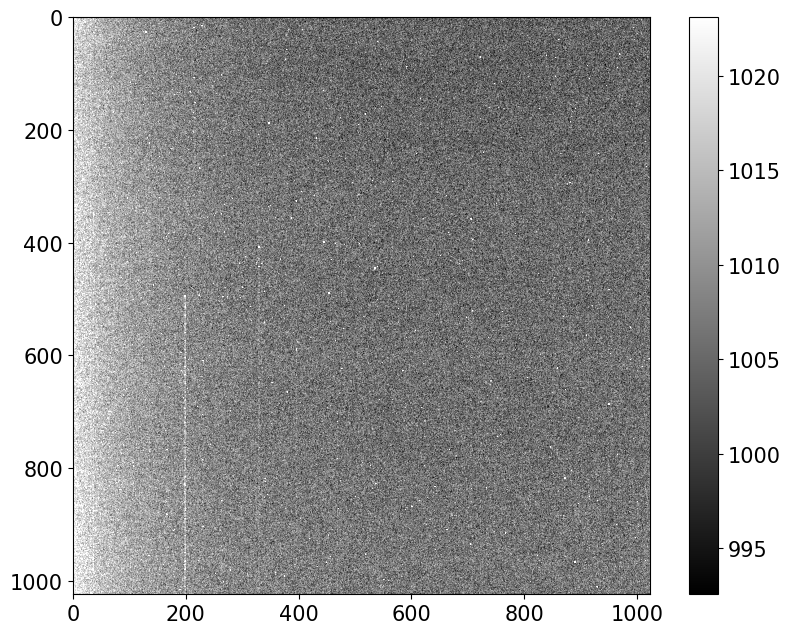

In [5]:
#We show one of the bias frames as an image.

print(f'Standard Deviation: ',np.std(bias_frames[4]))
plt.imshow(bias_frames[4], cmap='gray', vmin=(np.mean(bias_frames[1])-np.std(bias_frames[1])), vmax=(np.mean(bias_frames[1])+np.std(bias_frames[1])))
plt.colorbar()
plt.show()

In [6]:
##Loop that flattens each bias frame and appends it into another list called flat_bias_frames

flat_bias_frames=[]
for i in range(10):
    flat_bias_frames.append(bias_frames[i].flatten())

C:\Users\lenfn\AppData\Local\Temp\ipykernel_26296\2728697331.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(stats.mode(flat_bias_frames[1])[0][0]+(3*np.std(flat_bias_frames[1])))


1052.8340669527113


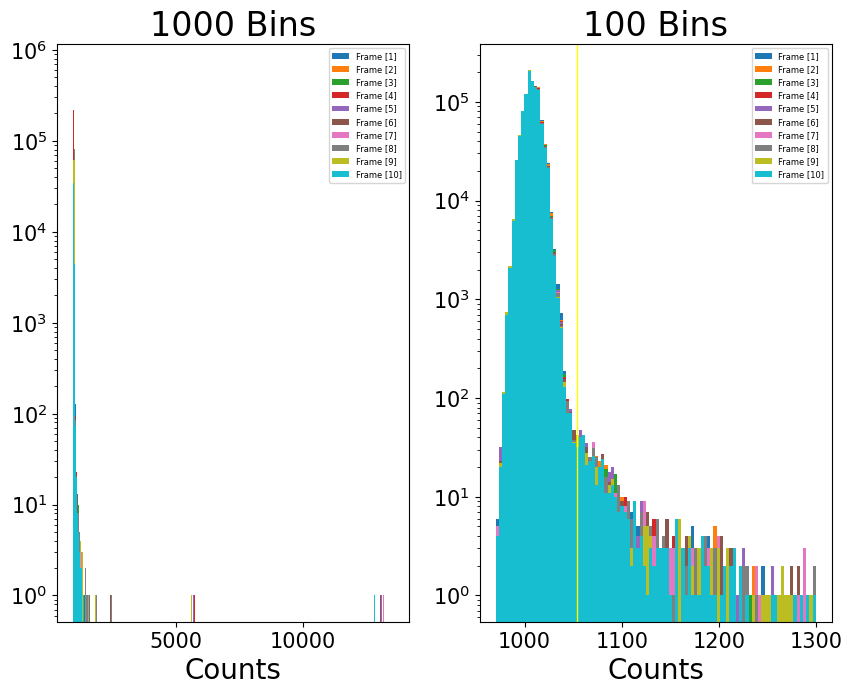

In [7]:
fig, (axes1, axes2)= plt.subplots(nrows=1, ncols=2)
nbins=100
for i in range(10):
    axes1.hist(flat_bias_frames[i], bins=1000, label=f'Frame {[i+1]}')
    axes1.set_yscale('log')
    axes2.hist(flat_bias_frames[i], range=[970,1300], bins=100, label=f'Frame {[i+1]}')
    axes2.set_yscale('log')
    
plt.legend(loc='upper right', prop={'size': 6})
axes1.set_xlabel('Counts')
axes1.set_title('1000 Bins')
axes1.legend(loc='upper right', prop={'size':6})
axes2.set_title('100 Bins')
axes2.axvline(x=np.mean(flat_bias_frames[1])+(3*np.std(flat_bias_frames[1])), linewidth=1.0, color="yellow")
plt.xlabel('Counts')
print(stats.mode(flat_bias_frames[1])[0][0]+(3*np.std(flat_bias_frames[1])))
plt.show()

In [8]:
##Loop that appends only the pixels above the defined cut of each bias frame into a list called bias_hot_pixels, 
##representing the hot pixels. By calculating the amount of hot pixels in each frame and dividing it by the total amount of pixels,
## we find the overall percetange of hot pixels for each frame.

bias_hot_pixels=[]
for i in range(len(flat_bias_frames)):
    bias_hot_pixels.append(bias_frames[i]>1055)
    print(f'Number of pixels cut: ', bias_hot_pixels[i].sum())
    print(f'Percentage of pixels cut: ', (bias_hot_pixels[i].sum()/len(flat_bias_frames[i]))*100)

Number of pixels cut:  410
Percentage of pixels cut:  0.03910064697265625
Number of pixels cut:  404
Percentage of pixels cut:  0.0385284423828125
Number of pixels cut:  390
Percentage of pixels cut:  0.03719329833984375
Number of pixels cut:  374
Percentage of pixels cut:  0.03566741943359375
Number of pixels cut:  394
Percentage of pixels cut:  0.03757476806640625
Number of pixels cut:  366
Percentage of pixels cut:  0.03490447998046875
Number of pixels cut:  387
Percentage of pixels cut:  0.036907196044921875
Number of pixels cut:  370
Percentage of pixels cut:  0.03528594970703125
Number of pixels cut:  358
Percentage of pixels cut:  0.03414154052734375
Number of pixels cut:  387
Percentage of pixels cut:  0.036907196044921875


## 2. calculating and overplotting a normal distribution with the mean and standard deviation

In [9]:
## Since we'll be creating multiple histograms to show multiple frames, we defined a function that allows us to easily create
## a figure with multiple rows and columns to show the count distribution of each frame used.

def multi_hist_plots(data_list, titles=None, suffix='', prefix='', nrows=3, ncols=3, bins=100, figsize=(18, 15), wspace=0.1, hspace=0.2, yscale='log', ylim=(0.9, 1e6), hist_range=None, bulk_range=False):
    """
    Plots multiple histograms from a list of data arrays with options for titles, bin range, and axis scaling.

    Parameters:
    - data_list: List of arrays to be plotted as histograms.
    - titles: List of titles for each plot (must include list of titles).
    - suffix: A string to append to each title (default is '').
    - prefix: A string to prepend to each title (default is '').
    - nrows: Number of rows in the subplot grid (default is 3).
    - ncols: Number of columns in the subplot grid (default is 3).
    - bins: Number of histogram bins (default is 100).
    - figsize: Size of the overall figure (default is (18, 15)).
    - wspace: Width space between subplots (default is 0.1).
    - hspace: Height space between subplots (default is 0.2).
    - yscale: Scale for y-axis (default is 'log').
    - hist_range: Tuple specifying the lower and upper range of the bins (default is None, which uses full data range).
    - bulk_range: If True, uses the mean +/- standard deviation of data for range.

    Returns:
    - fig: The created figure object with subplots.
    """
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    num_plots = len(data_list)
    
    if hist_range is None:
        if bulk_range:
            mean=[np.mean(data_list[i]) for i in range(num_plots)]
            std=[np.std(data_list[i]) for i in range(num_plots)]
            hist_range = [(mean[i]-(3*std[i]), mean[i]+(3*std[i])) for i in range(num_plots)]
        else:
            hist_range = [(np.min(data_list[i]), np.max(data_list[i])) for i in range(num_plots)]
    
    for i in range(num_plots):
        subp = fig.add_subplot(nrows, ncols, i+1)
        subp.hist(data_list[i], bins=bins, range=hist_range[i])
        title = f'{prefix}{titles[i]}{suffix}'
        subp.set_title(title)
        subp.set_yscale(yscale)
        subp.set_ylim(ylim)

    return fig

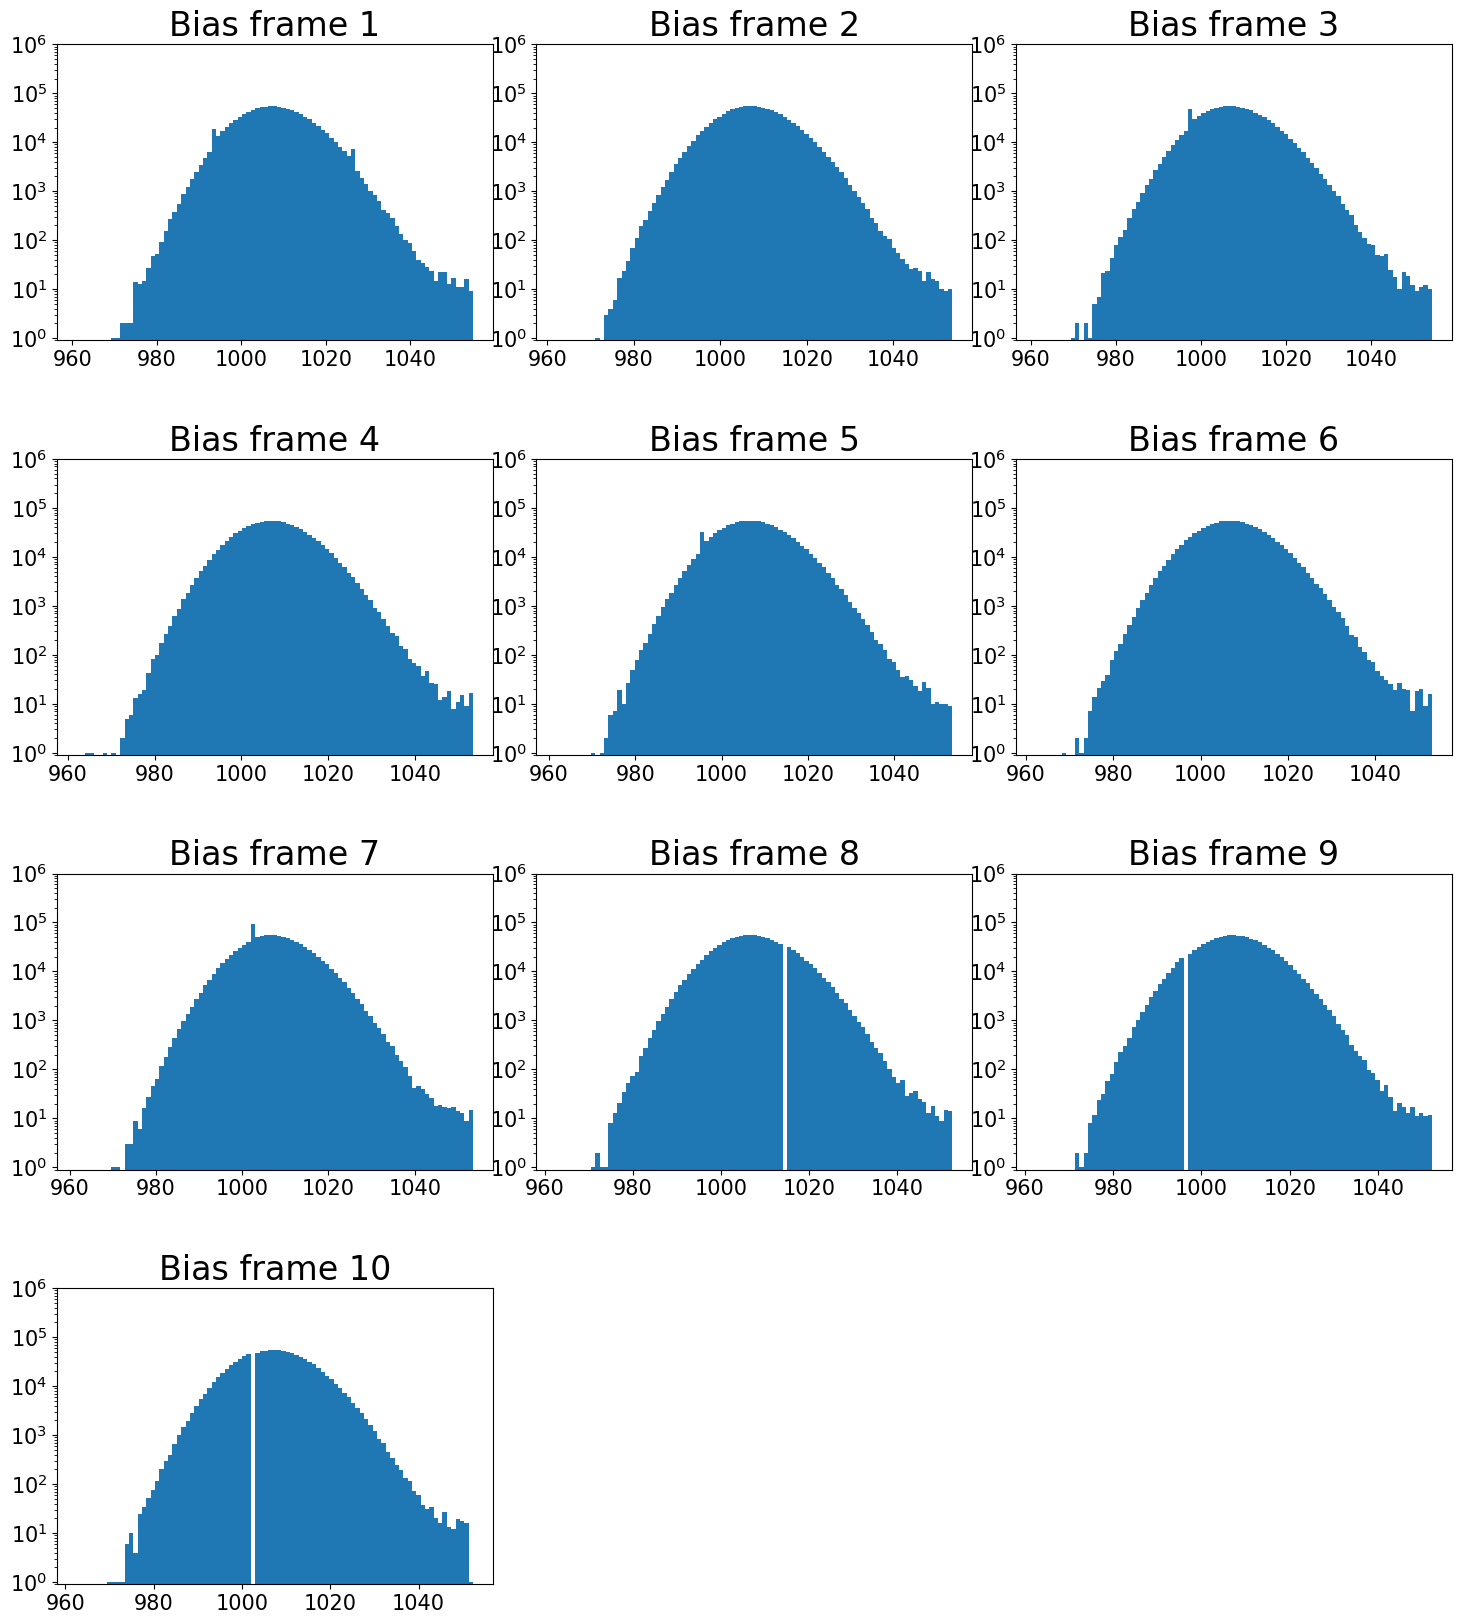

In [10]:
frame_num=[1,2,3,4,5,6,7,8,9,10]
multi_hist_plots(flat_bias_frames, titles=frame_num, prefix='Bias frame ', bins=91,  nrows=4, figsize=(18, 20), hspace=.4, bulk_range=True)
plt.show()

C:\Users\lenfn\AppData\Local\Temp\ipykernel_26296\3117968833.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  b_mode=stats.mode(bias_cutcounts)[0][0]


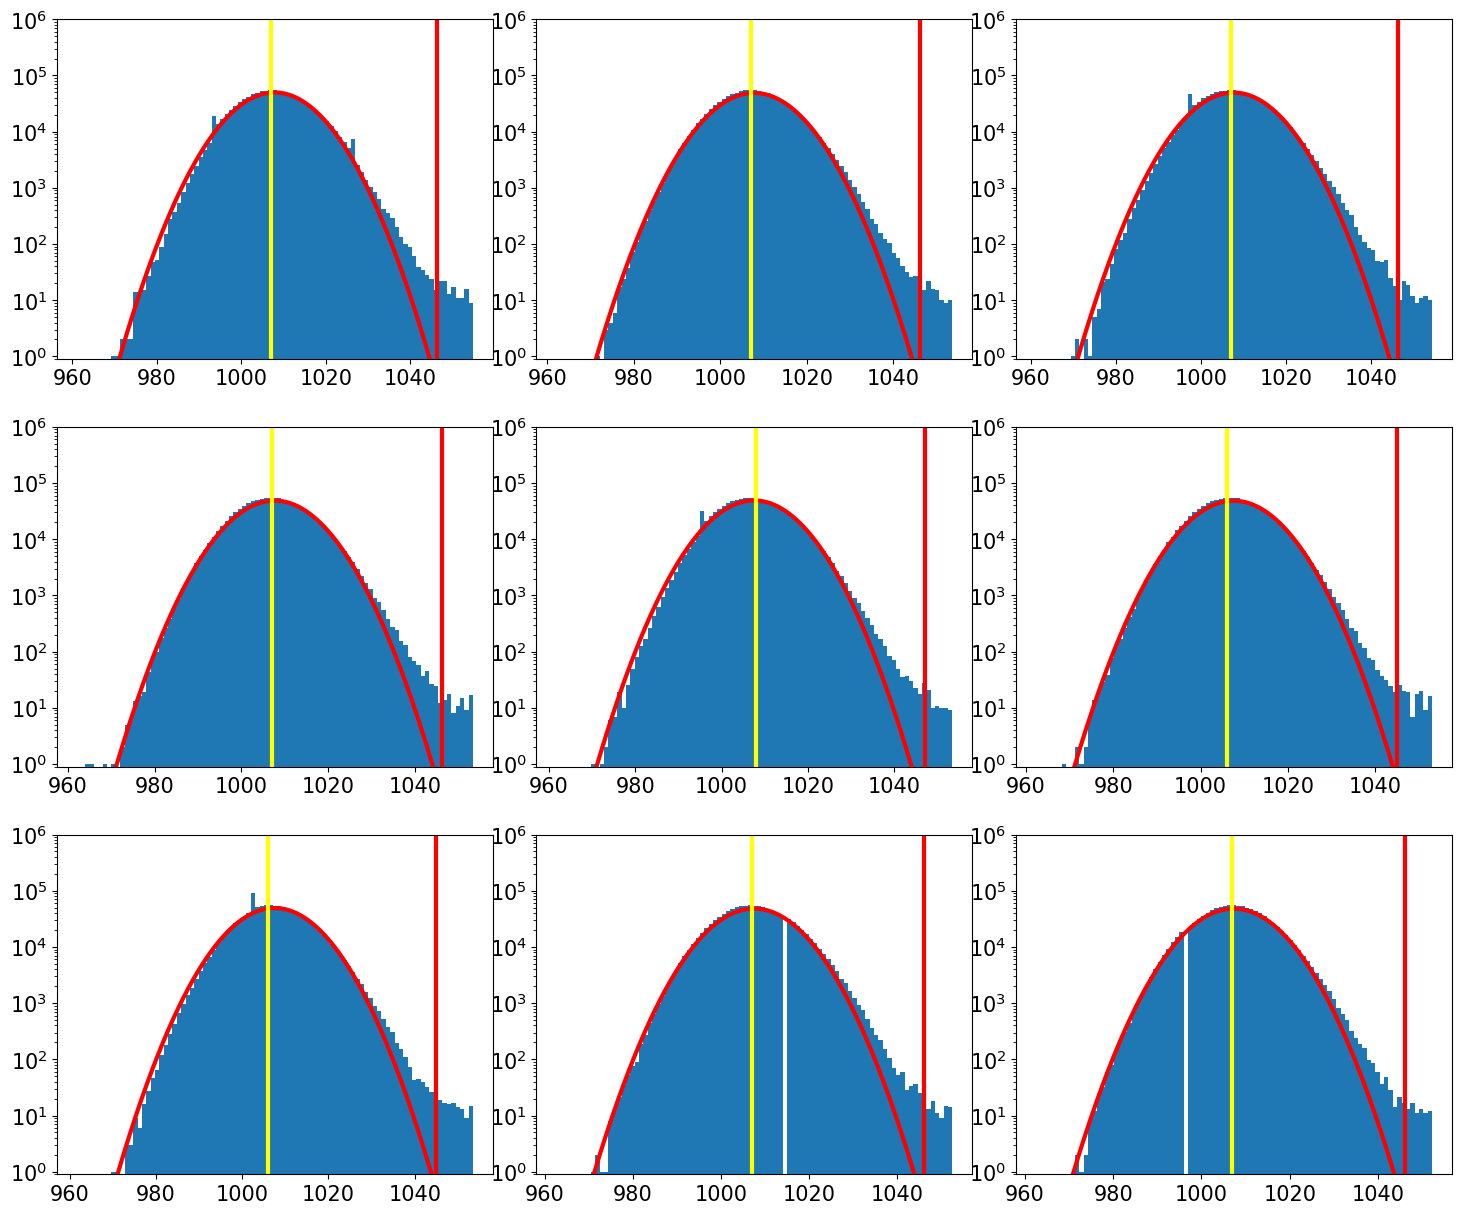

In [11]:
fig = plt.figure(figsize=(18, 15))  # width, height in inches
plt.subplots_adjust(wspace=.1, hspace=.2)
cut_bias_frames=[]
for i in range(9):
    bmin=np.mean(flat_bias_frames[i])-(3*(np.std(flat_bias_frames[i])))
    bmax=np.mean(flat_bias_frames[i])+(3*(np.std(flat_bias_frames[i])))
    bf_normalization=(bmax-bmin)/nbins*len(flat_bias_frames[i][(flat_bias_frames[i]>=bmin) & (flat_bias_frames[i]<=bmax)])


    bias_cutcounts=flat_bias_frames[i][(flat_bias_frames[i]>=bmin) & (flat_bias_frames[i]<=bmax)]

    b_mu=np.mean(bias_cutcounts)
    b_sig=np.std(bias_cutcounts)
    b_mode=stats.mode(bias_cutcounts)[0][0]

    bxarray=np.linspace(bmin, bmax, nbins*10)
    byarray=bf_normalization*norm.pdf(bxarray, loc=b_mu, scale=b_sig)
    bf_mean=(np.mean(flat_bias_frames[i]))
    bf_std=(np.std(flat_bias_frames[i]))
    sub = fig.add_subplot(3, 3, i+1)
    sub.hist(flat_bias_frames[i], range=[bf_mean-(3*bf_std), bf_mean+(3*bf_std)], bins=91)
    sub.plot(bxarray,byarray,color="red",linewidth=3.0)
    sub.axvline(x=b_mode, linewidth=3.0, color="yellow")
    sub.axvline(x=b_mode+(5*b_sig), linewidth=3.0, color="red")
    sub.set_yscale('log')
    sub.set_ylim([0.9,1e6])
    
    cut_bias_frames.append(flat_bias_frames[i][flat_bias_frames[i]<(b_mode+(5*b_sig))])

In [12]:
for i in range(9):
    print(np.mean(cut_bias_frames[i]))
for j in range(9):
    print(np.std(cut_bias_frames[j]))
    

1007.8845553822152
1007.7864711298548
1007.6549094330118
1007.6236081771916
1007.5429765431569
1007.5866421514839
1007.4821432149561
1007.5139744545082
1007.2896453483879
7.8572257061610795
7.823667717988024
7.8296855240252885
7.806730345240776
7.80877485994947
7.807817395224145
7.7813099355007385
7.800659268063634
7.796379674846267


# 4.2 Dark Frames
## 4.2.1. Combining series of 10 dark frames.

In [14]:
dark_0c30_frames = []
for i in range(10):
    dfilename = f'dark_0C_30s_visible_.0000000{i}.DARK.FIT'
    dframe = f'/Users/lenfn/Documents/AST 443/Group5_data_lab1/photometry/dark_frames/{dfilename}'
    dframe_data = fits.open(dframe)    
    dark_0c30_frames.append(dframe_data[0].data)

In [15]:
masterd_0c30_f= np.mean(dark_0c30_frames, axis=0)

In [16]:
meandf=np.mean(masterd_0c30_f)
stddf=np.std(masterd_0c30_f)
print(meandf-stddf)
print(meandf+stddf)

873.5625372935551
1200.945565695641


<function matplotlib.pyplot.show(close=None, block=None)>

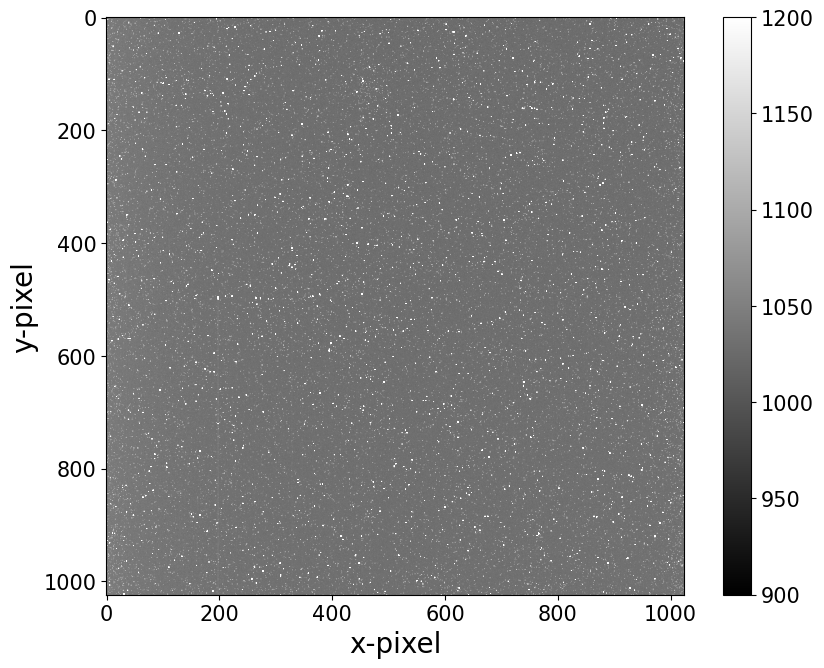

In [23]:
plt.imshow(masterd_0c30_f, vmin=900, vmax=1200, cmap='gray')
plt.colorbar()
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
plt.show

In [20]:
np.count_nonzero(np.array(masterd_0c30_f[masterd_0c30_f>1200]))

6472

6508
6508
6478
6509
6487
6496
6461
6471
6486
6494


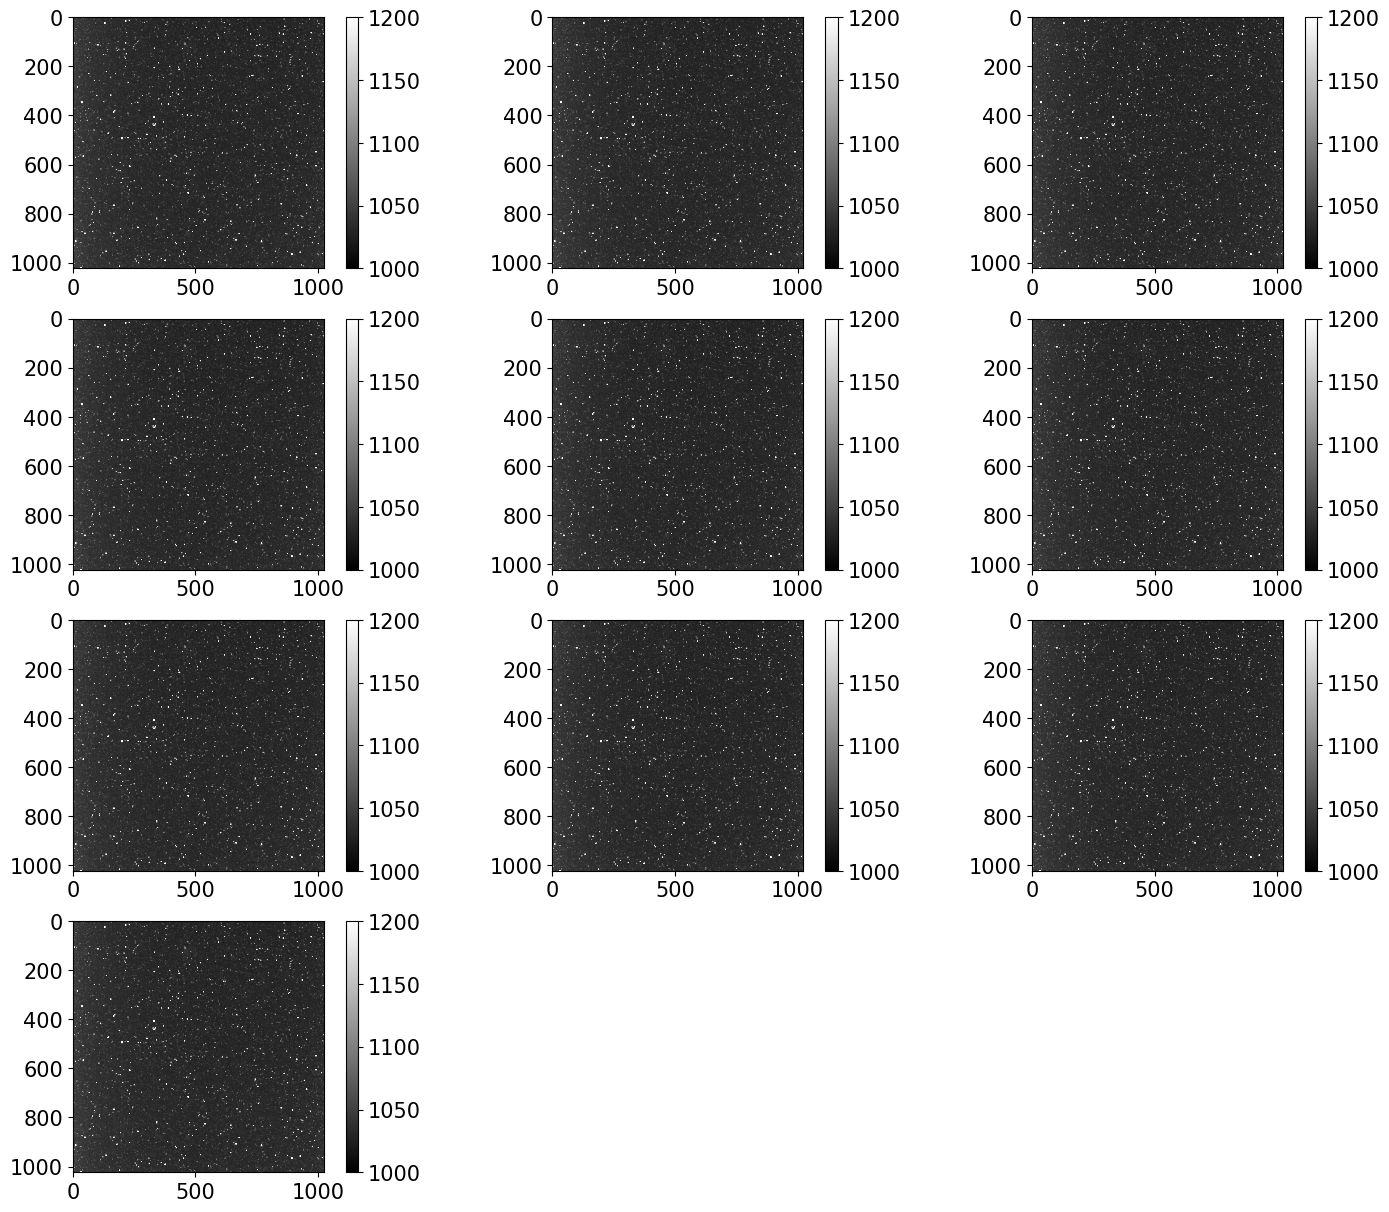

In [24]:
fig = plt.figure(figsize=(18, 15))  # width, height in inches
plt.subplots_adjust(wspace=.1, hspace=.2)
for i in range(10):
    sub = fig.add_subplot(4, 3, i+1)
    cb=sub.imshow(dark_0c30_frames[i], vmin=1000, vmax=1200, cmap='gray')
    fig.colorbar(cb, orientation='vertical', fraction=.33)
    print(np.count_nonzero(np.array(dark_0c30_frames[i][dark_0c30_frames[i]>1200])))

In [29]:
copy_masterd_0c30_f=np.zeros((1024,1024))
np.copyto(copy_masterd_0c30_f, masterd_0c30_f)

In [34]:
copy_masterd_0c30_f[copy_masterd_0c30_f > 1200] = np.median(masterd_0c30_f)

In [35]:
cut_mean_df=np.mean(copy_masterd_0c30_f)
cut_std_df=np.std(copy_masterd_0c30_f)

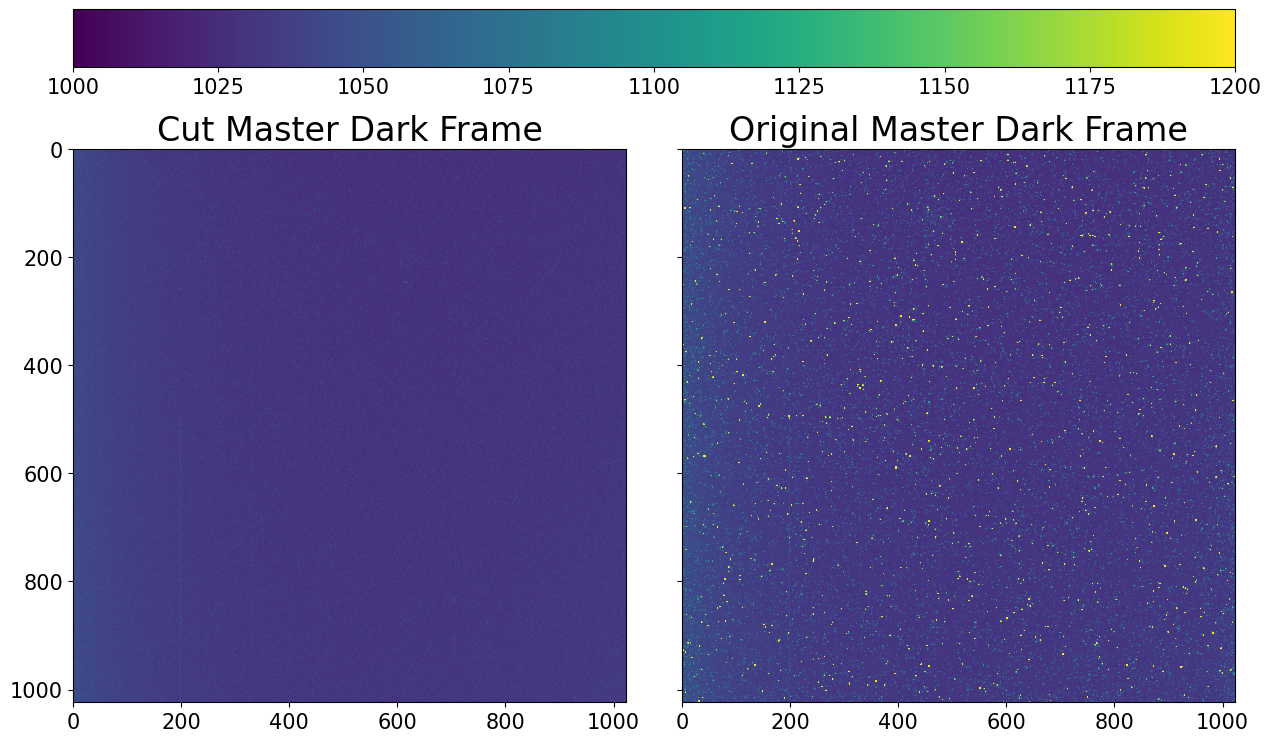

In [37]:
figs, axs= plt.subplots (1, 2, figsize=(15,12), sharex=True, sharey=True)


norm = colors.Normalize(vmin=1000, vmax=1200)

cb=axs[0].imshow(copy_masterd_0c30_f,norm=norm)
axs[0].set_title('Cut Master Dark Frame')
#plt.colorbar(cb, ax=axs[0,0])
axs[1].imshow(masterd_0c30_f,vmin=1000, vmax=1200)
axs[1].set_title('Original Master Dark Frame')

fig.colorbar(cb, ax=axs, orientation='horizontal', fraction=.75)

figs.subplots_adjust(wspace=0.1, hspace=0.1)

## Each frame is very similar looking but there are slight differences in their warmth. It could be from the fact that the temperature slightly fluctuated around 0C, so those slight temperature changes could have created very faint warmer or colder pixels.

## 4.2.2 Measuring the mean and the standard deviation of the cut dark frames.

In [38]:
exposure_times=[10,20,30,40,50,60,90,120]
dark_0c_f=[]

for i in range(len(exposure_times)):
    frames_file=f'/Users/lenfn/Documents/AST 443/Group5_data_lab1/photometry/dark_frames/dark_0C_{exposure_times[i]}s_visible_.00000000.DARK.FIT'
    frames_file_data=fits.open(frames_file)
    dark_0c_f.append(frames_file_data[0].data)

In [39]:
copy_dark_0c_f=dark_0c_f.copy()

In [40]:
flat_dark_0c_frames=[]
for i in range(8):
    flat_df=dark_0c_f[i].flatten()
    flat_dark_0c_frames.append(flat_df)
    

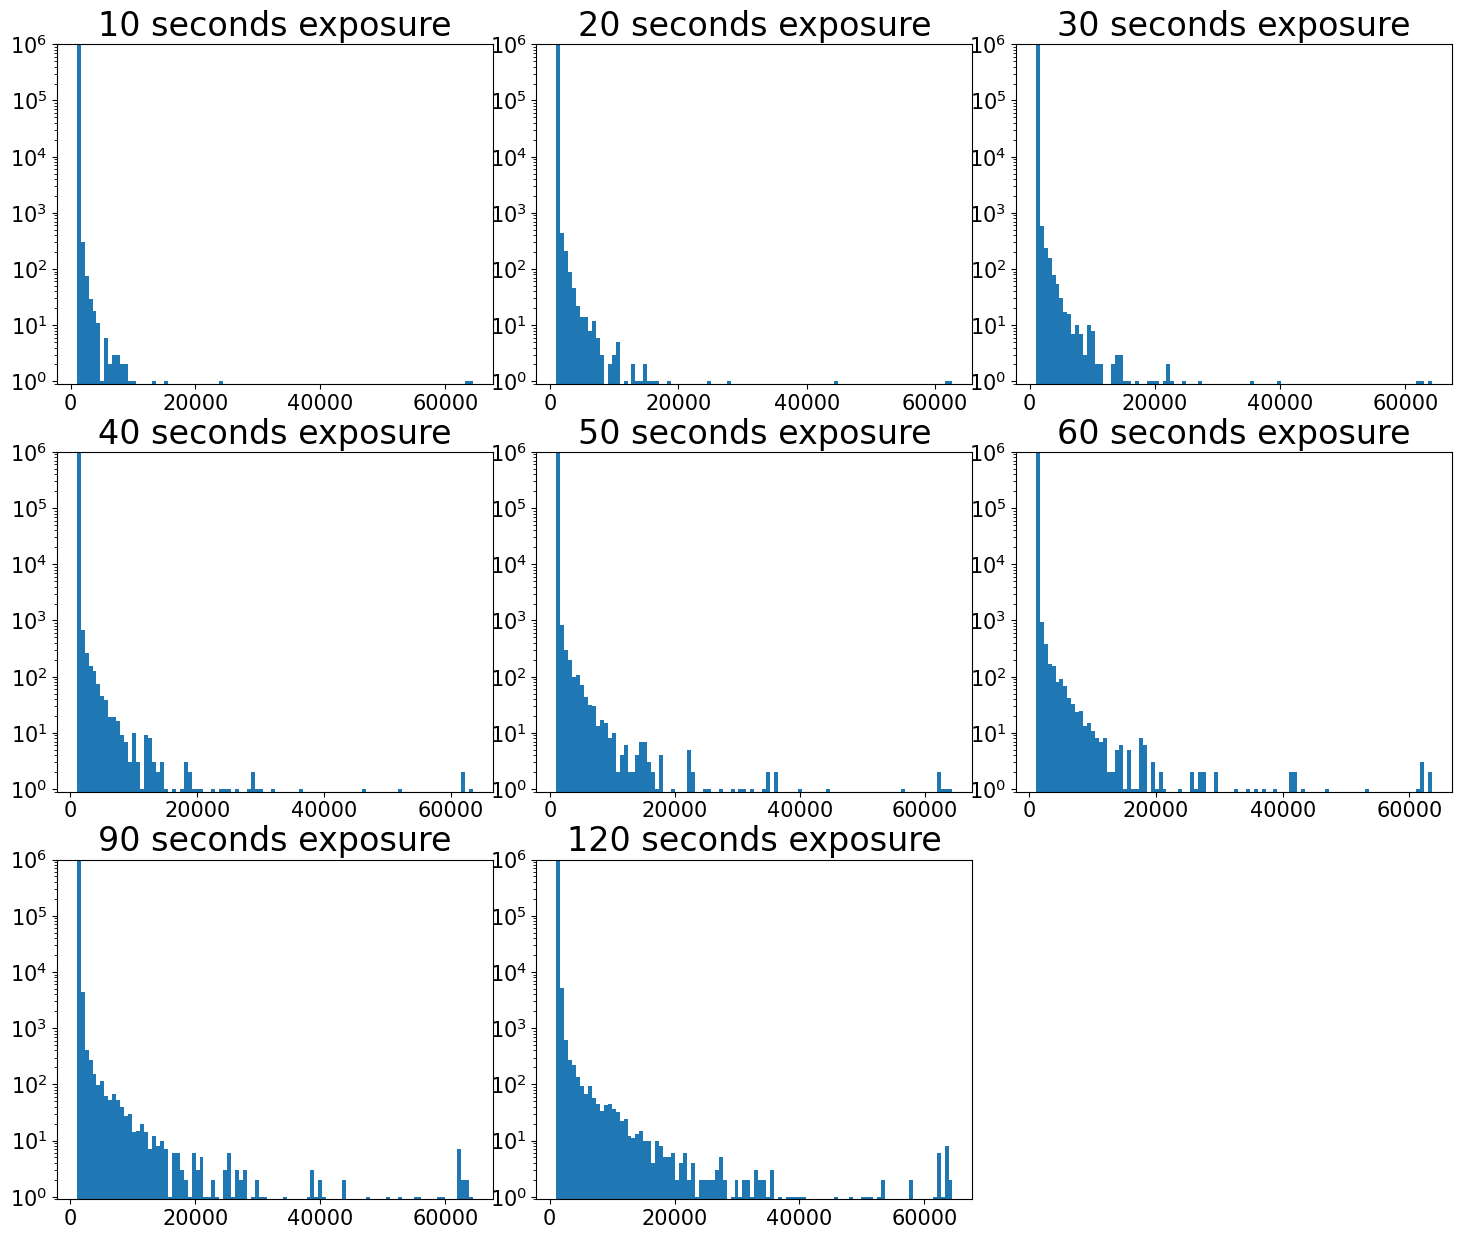

In [41]:
multi_hist_plots(flat_dark_0c_frames, titles=exposure_times, suffix=' seconds exposure', hist_range=None)
plt.show()

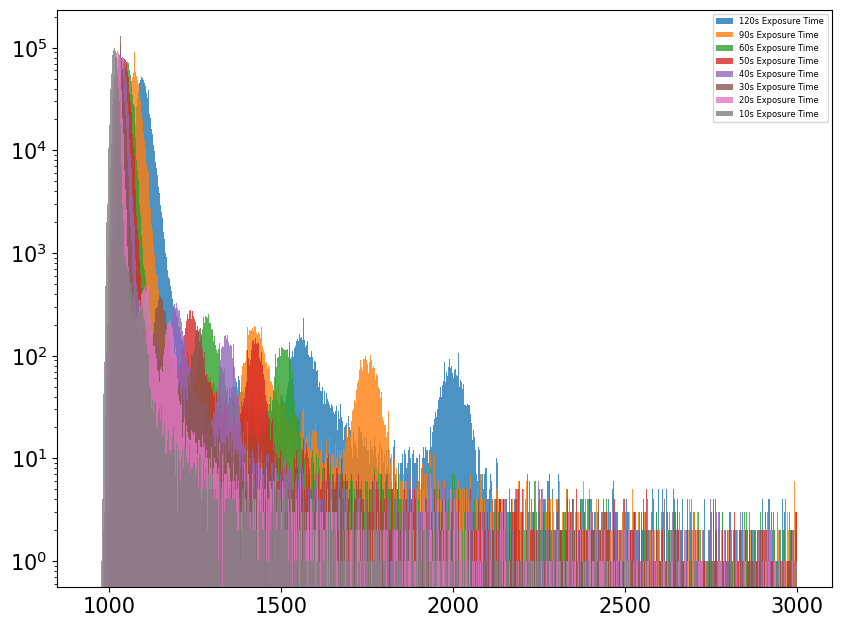

In [42]:
for i in range(8):
    plt.hist(flat_dark_0c_frames[7-i], bins=1000,range=[950, 3000], alpha=0.8, label=f'{exposure_times[7-i]}s Exposure Time')
    plt.legend(loc='upper right', prop={'size': 6})
    plt.yscale('log')


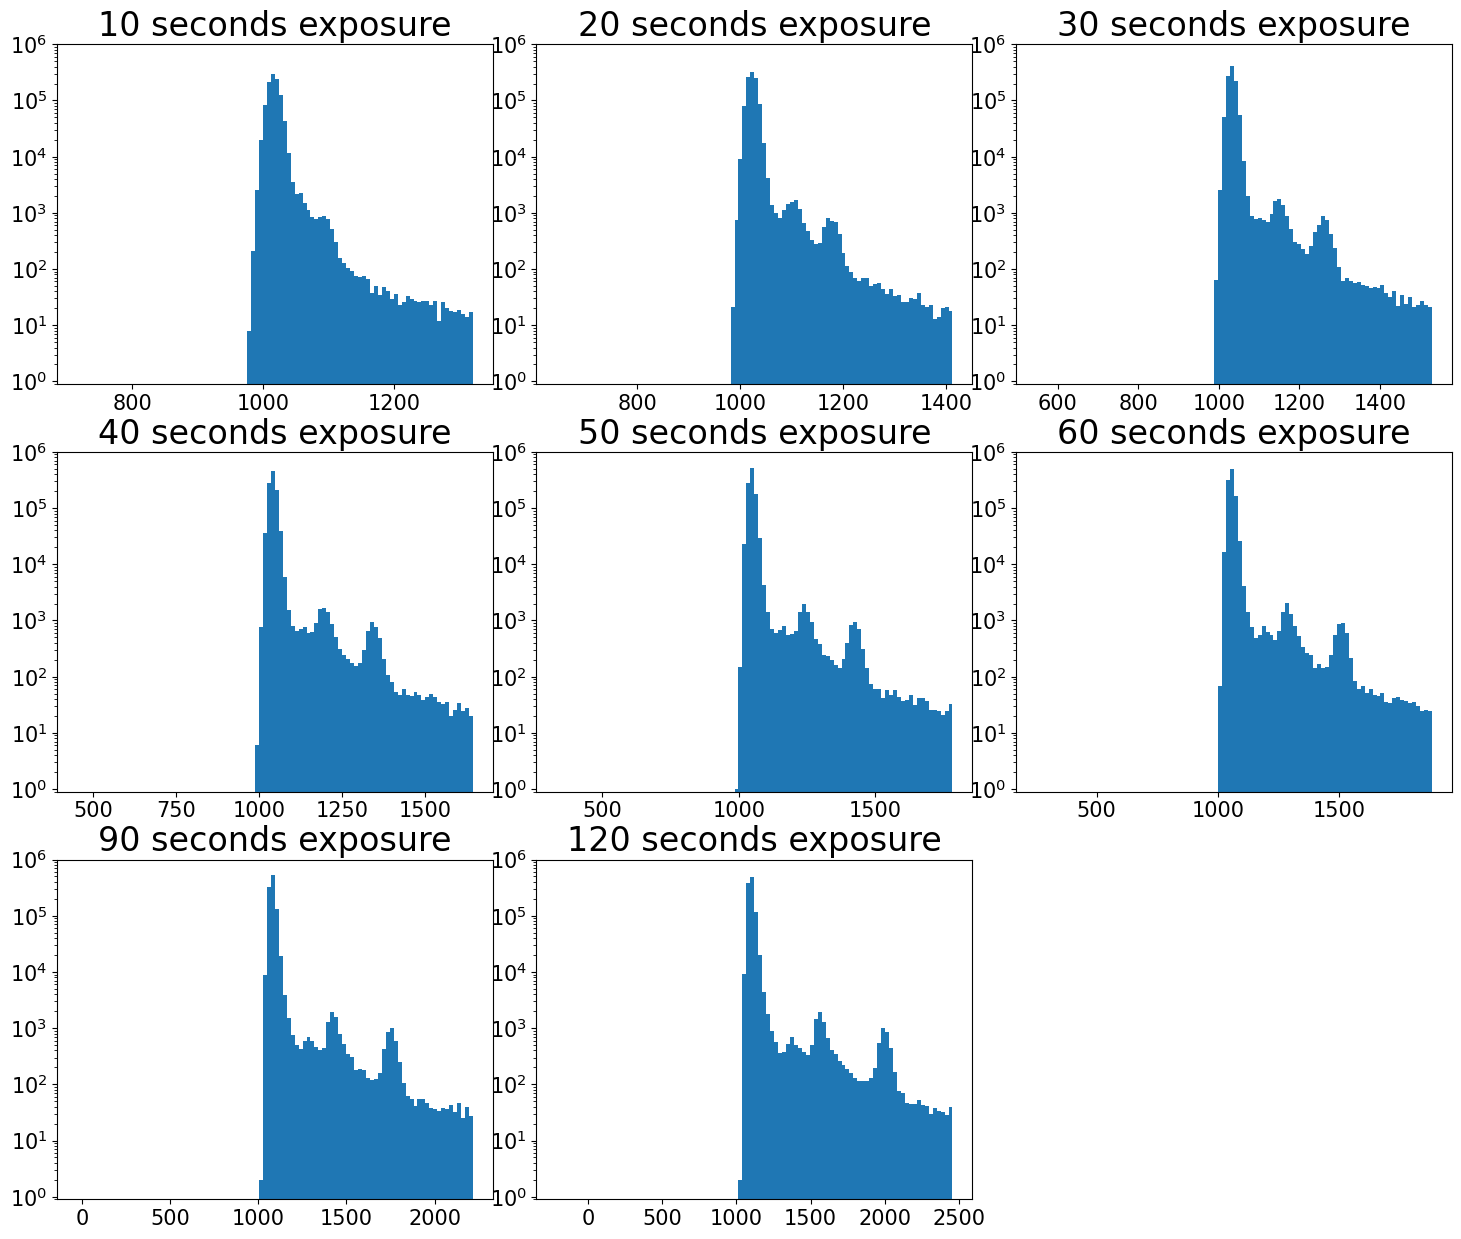

In [43]:

multi_hist_plots(flat_dark_0c_frames, titles=exposure_times, suffix=' seconds exposure', hist_range=None, bulk_range=True)
plt.show()

C:\Users\lenfn\AppData\Local\Temp\ipykernel_26296\1655750577.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  fmode=stats.mode(fcutcounts)[0][0]


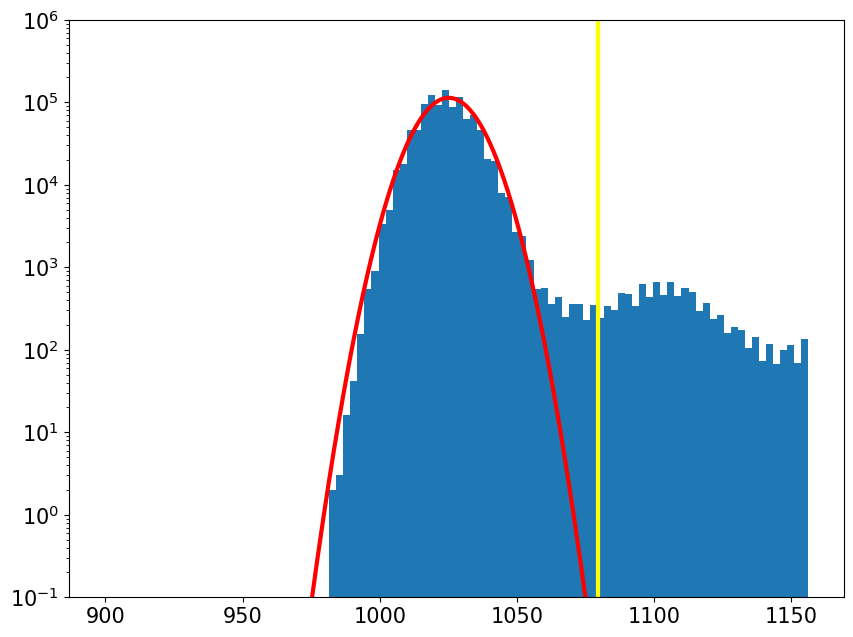

In [46]:
fmin=np.mean(flat_dark_0c_frames[1])-np.std(flat_dark_0c_frames[1])
fmax=np.mean(flat_dark_0c_frames[1])+np.std(flat_dark_0c_frames[1])
df_normalization=(fmax-fmin)/nbins*len(flat_dark_0c_frames[1][(flat_dark_0c_frames[1]>=fmin) & (flat_dark_0c_frames[1]<=fmax)])


fcutcounts=flat_dark_0c_frames[1][(flat_dark_0c_frames[1]>=fmin) & (flat_dark_0c_frames[1]<=fmax)]

fmu=np.mean(fcutcounts)
fsig=np.std(fcutcounts)*(fmin/fmax)
fmode=stats.mode(fcutcounts)[0][0]

fxarray=np.linspace(fmin, fmax, nbins*10)
fyarray=df_normalization*norm.pdf(fxarray, loc=fmu, scale=fsig)
                                  
plt.hist(flat_dark_0c_frames[1],range=[fmin,fmax], bins=nbins);
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(fxarray,fyarray,color="red",linewidth=3.0)
plt.axvline(x=fmode+(6*fsig),linewidth=3.0,color="yellow")

C:\Users\lenfn\AppData\Local\Temp\ipykernel_26296\3150878364.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  fmode=stats.mode(fcutcounts)[0][0]


1066.5893119865875
1079.6117182281366
1095.7272694028752
1109.6445169643162
1124.9522761091266
1137.9424175269858
1170.1022065455738
1187.1831007842347


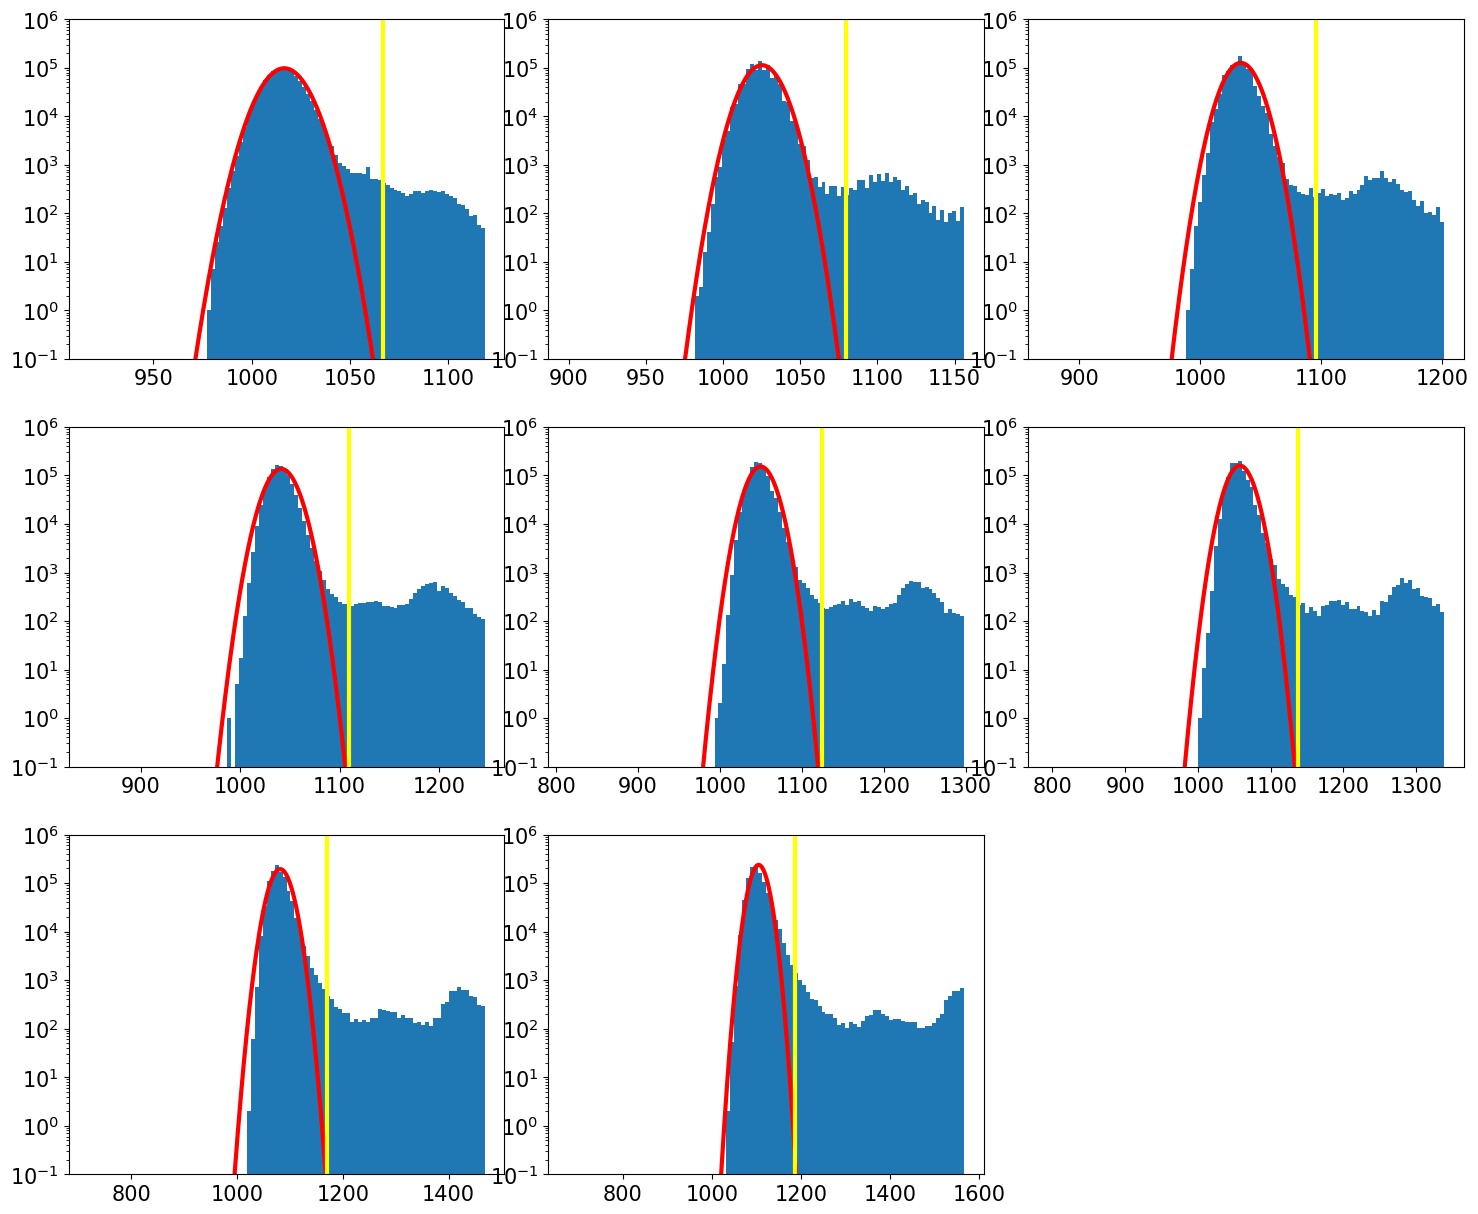

In [47]:
fig = plt.figure(figsize=(18, 15))  # width, height in inches
plt.subplots_adjust(wspace=.1, hspace=.2)
dark_frames_bulk=[]
for i in range(8):
    fmin=np.mean(flat_dark_0c_frames[i])-np.std(flat_dark_0c_frames[i])
    fmax=np.mean(flat_dark_0c_frames[i])+np.std(flat_dark_0c_frames[i])
    df_normalization=(fmax-fmin)/nbins*len(flat_dark_0c_frames[i][(flat_dark_0c_frames[i]>=fmin) & (flat_dark_0c_frames[i]<=fmax)])

    fcutcounts=flat_dark_0c_frames[i][(flat_dark_0c_frames[i]>=fmin) & (flat_dark_0c_frames[i]<=fmax)]

    fmu=np.mean(fcutcounts)
    fsig=np.std(fcutcounts)*(fmin/fmax)
    fmode=stats.mode(fcutcounts)[0][0]

    fxarray=np.linspace(fmin, fmax, nbins*10)
    fyarray=df_normalization*norm.pdf(fxarray, loc=fmu, scale=fsig)
    
    subp = fig.add_subplot(3, 3, i+1)
    subp.hist(flat_dark_0c_frames[i], range=[fmin,fmax], bins=nbins)
    subp.plot(fxarray,fyarray,color="red",linewidth=3.0)
    subp.axvline(x=fmode+(6*fsig),linewidth=3.0,color="yellow")
    subp.set_yscale('log')
    subp.set_ylim([0.1,1e6])
    
    print(fmode+(6*fsig))
    dark_frames_bulk.append(flat_dark_0c_frames[i][flat_dark_0c_frames[i]<(fmode+(6*fsig))])
#plt.savefig("dark_frames_gaussian.png", dpi=300)

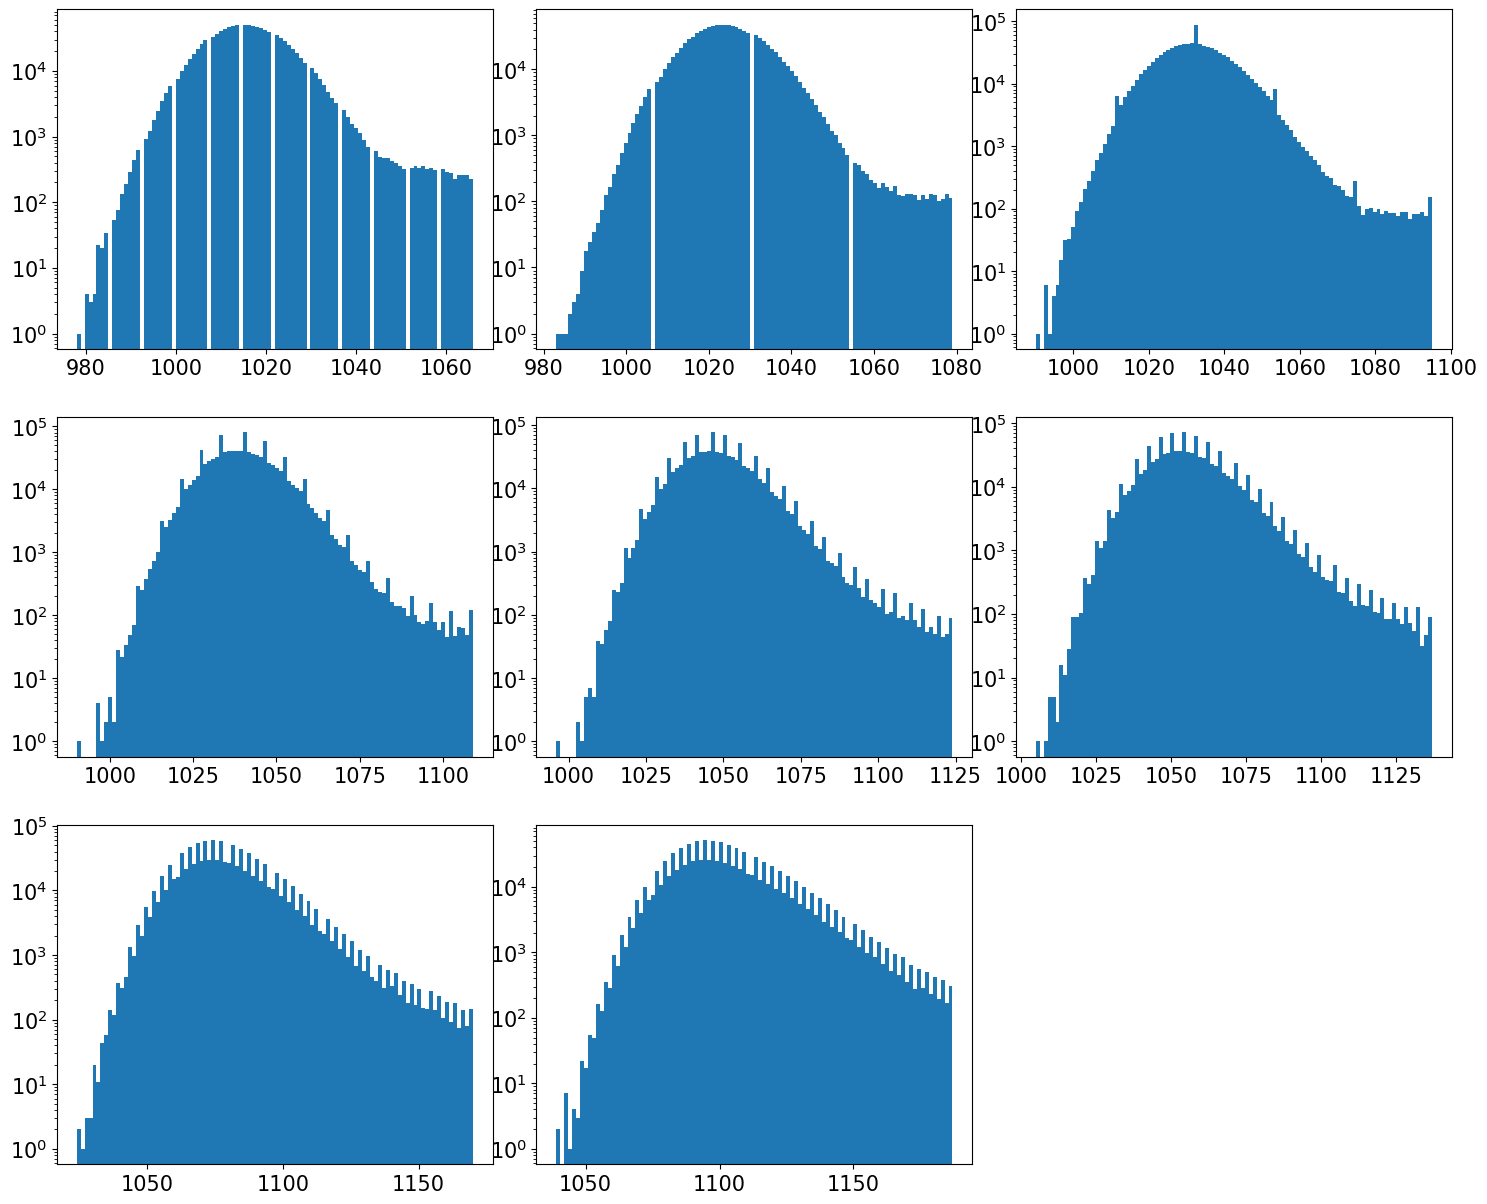

In [48]:
fig = plt.figure(figsize=(18, 15))  # width, height in inches
plt.subplots_adjust(wspace=.1, hspace=.2)
for i in range(8):
    dfb_mean=(np.mean(dark_frames_bulk[i]))
    dfb_std=(np.std(dark_frames_bulk[i]))
    subp = fig.add_subplot(3, 3, i+1)
    subp.hist(dark_frames_bulk[i], bins=nbins)
    subp.set_yscale('log')

In [49]:
df_bulk_mean=[]
df_bulk_std=[]
for i in range(8):
    df_bulk_mean.append(np.mean(dark_frames_bulk[i]))
    df_bulk_std.append(np.std(dark_frames_bulk[i]))
    print(df_bulk_mean[i])
    print(df_bulk_std[i])

1016.083948535484
8.93452727164149
1024.4324875021648
9.195627026839421
1032.460005347863
9.85745468561842
1040.0039216142509
10.66502947629112
1047.9681746104868
11.606372852267711
1055.5730825312653
12.610849425123986
1078.4982667033173
15.755855176626696
1101.7681441987088
18.56831699542286


In [50]:
sys_err=[]
for i in range(8):
    sys_err.append((df_bulk_std[i])/np.sqrt(len(dark_frames_bulk[i])))
    
print(sys_err)

[0.008760296198513876, 0.009045019544322082, 0.009702538762031152, 0.010501110614261858, 0.011430024929952562, 0.012421179078259464, 0.015528165710128652, 0.018328803184706866]


Text(0, 0.5, 'Mean Counts')

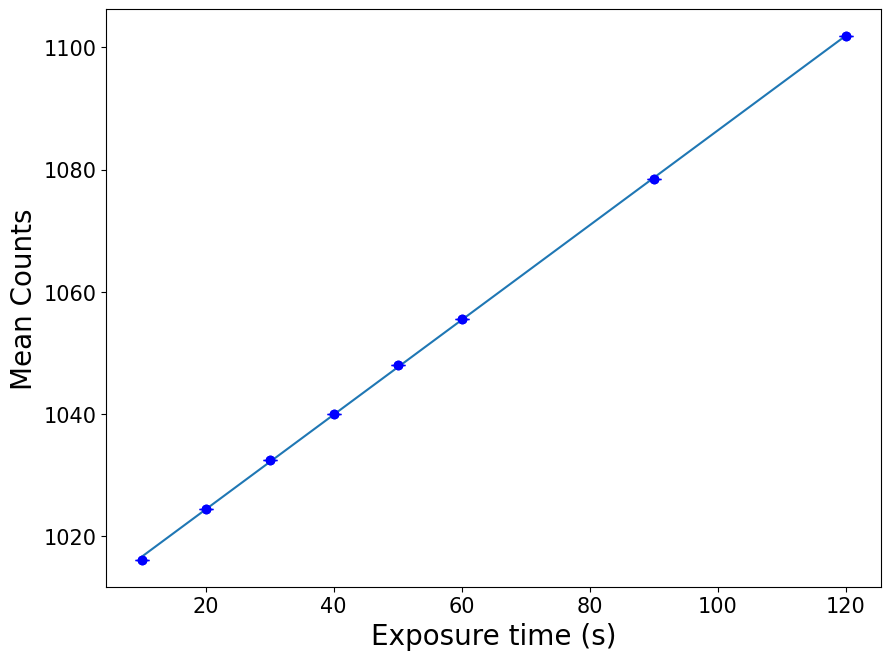

In [51]:
coef = np.polyfit(exposure_times,df_bulk_mean,1)
poly1d_fn = np.poly1d(coef)

plt.plot(exposure_times, df_bulk_mean, 'bo', exposure_times, poly1d_fn(exposure_times))
plt.errorbar(exposure_times, df_bulk_mean, yerr=sys_err, fmt='o', color="blue", capsize=5)
plt.xlabel('Exposure time (s)')
plt.ylabel('Mean Counts')

In [52]:
residual=[]
for i in range(len(exposure_times)):
    residual.append(df_bulk_mean[i]-poly1d_fn(exposure_times)[i])
    

(-2.0, 2.0)

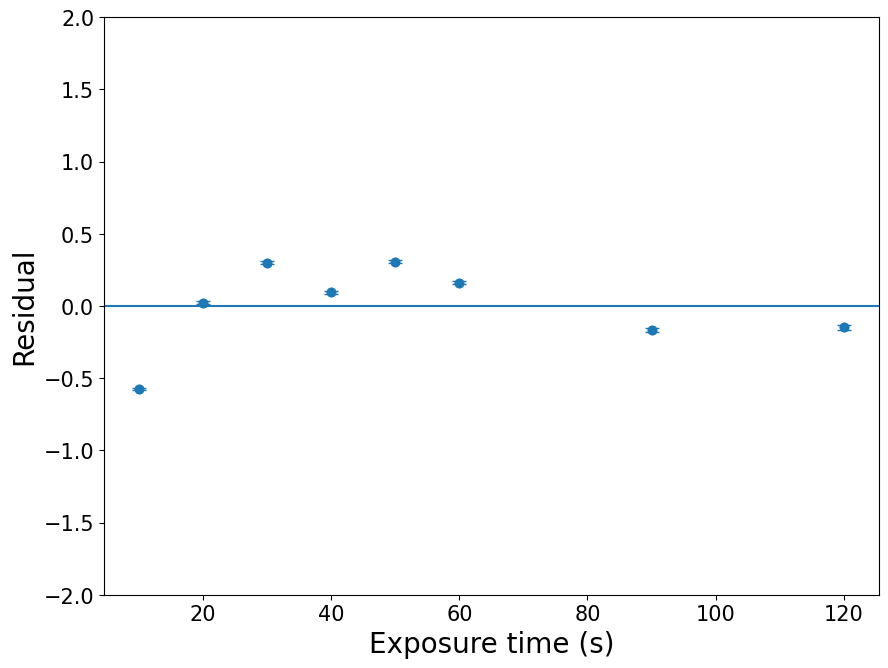

In [53]:
plt.scatter(exposure_times, residual)
#plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')
plt.errorbar(exposure_times, residual, yerr=sys_err, fmt='o', capsize=5)
plt.axhline(y=0)
plt.xlabel('Exposure time (s)')
plt.ylabel('Residual')
plt.ylim(-2, 2)
#plt.legend(loc="best")

In [54]:
dark_current=[(np.mean((dark_frames_bulk[i] * 2)/exposure_times[i])) for i in range(len(exposure_times))]

In [55]:
dark_current

[203.21678970709672,
 102.4432487502164,
 68.83066702319086,
 52.00019608071256,
 41.91872698441944,
 35.18576941770886,
 23.9666281489626,
 18.36280240331181]

#4.3. Imaging flat-fields

4.3 1.

In [9]:
flat2s_0= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.00000000.FLAT.FIT')
flat30_1= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000001.FLAT.FIT')
flat30_2= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000002.FLAT.FIT')
flat30_3= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000003.FLAT.FIT')
flat30_4= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000004.FLAT.FIT')
flat30_5= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000005.FLAT.FIT')
flat30_6= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000006.FLAT.FIT')
flat30_7= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000007.FLAT.FIT')
flat30_8= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000008.FLAT.FIT')
flat30_9= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000009.FLAT.FIT')

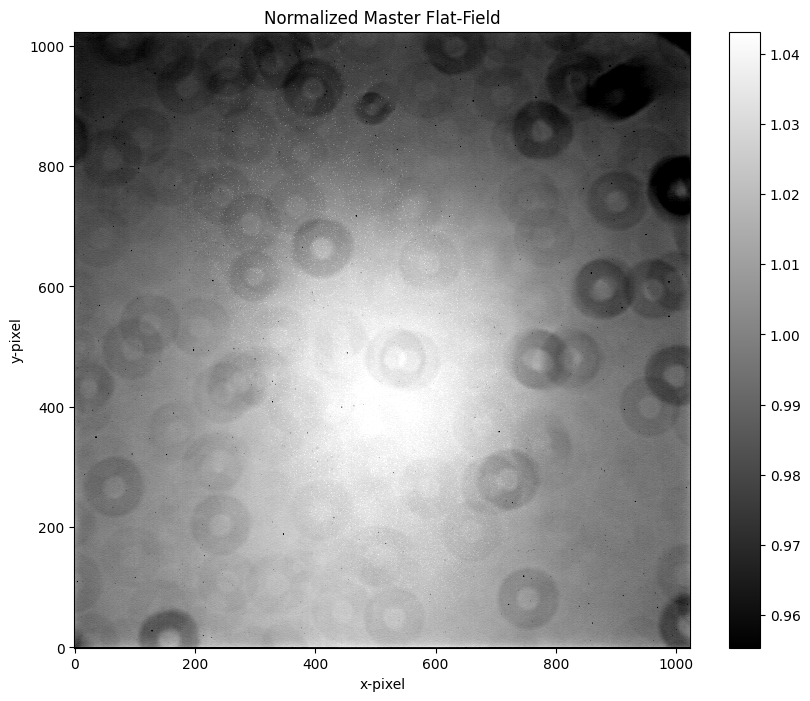

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from google.colab import drive

# Function to open and extract data from FITS files
def get_fits_data(filenames):
    data = []
    for filename in filenames:
        with fits.open(filename) as hdul:
            data.append(hdul[0].data)
    return np.array(data)

# List of flat-field files
flat_files = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.00000000.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000001.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000002.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000003.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000004.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000005.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000006.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000007.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000008.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_30s_visible_.00000009.FLAT.FIT'
]

# Load flat-field data
flat_data = get_fits_data(flat_files)

# Compute the median flat field
master_flat = np.median(flat_data, axis=0)

# Load dark frames
dark_files = [f'/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/Photometry/Dark frames/dark_0C_30s_visible_.0000000{i}.DARK.FIT' for i in range(10)]
dark_data = get_fits_data(dark_files)

# Compute the Master Dark
master_dark = np.median(dark_data, axis=0)

# Subtract Master Dark from Master Flat
final_frame = master_flat - master_dark

# Normalize the resulting frame
# Normalization using mean of non-zero pixels
non_zero_pixels = final_frame[final_frame > 0]
normalization_factor = np.mean(non_zero_pixels)
normalized_master_flat = final_frame / normalization_factor

# Plot the normalized master flat-field
plt.figure(figsize=(10, 8))
plt.imshow(normalized_master_flat, cmap='gray', origin='lower',
           vmin=np.percentile(normalized_master_flat, 1),
           vmax=np.percentile(normalized_master_flat, 99))
plt.colorbar()
plt.title('Normalized Master Flat-Field')
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
plt.show()

#4.3 2.
After running the code,the normalized_master_flat.FIT file will be in the Google Drive. Now you can open it with DS9. Light regions tend to get 1.02 to 1.05 and dark regions tend to get 0.94 to 0.97.

#4.3 3.
When a star is placed at the center versus the corner of an image, its observed magnitude can change, stars near the edges may appear dimmer.
The light from the star would be spread out over a larger area on the image sensor, resulting in a lower intensity of light detected at any given pixel. \\
$m_1 - m_2$ = -2.5 $log_{10} (\frac{0.94}{1.04})$ \\
$m_1 - m_2$ = 0.1097 \\
$m_1 - m_2$ $\approx$ 0.11

#4.3 4.
Plot a histogram of the counts in your master flat-field. Can you identify any dead pixels?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


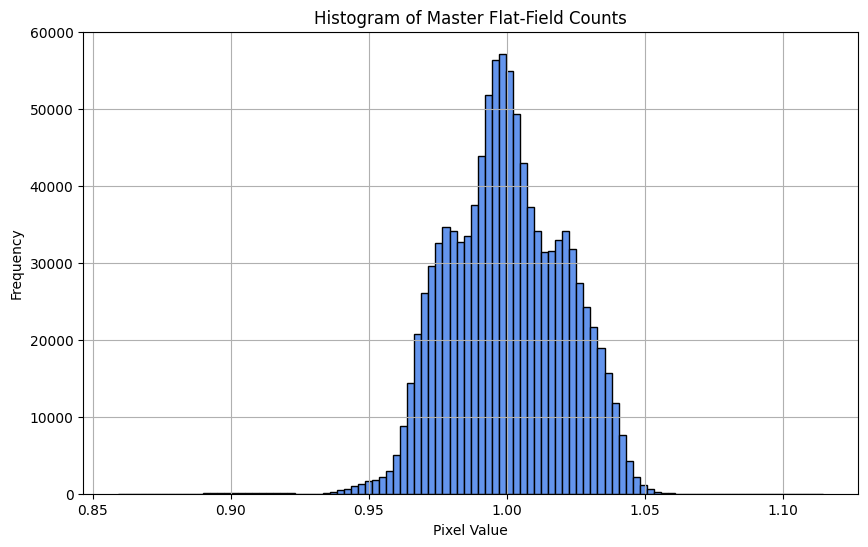

Normalization Factor: 58800.94


In [11]:
# Import necessary libraries
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Function to open and extract data from FITS files
def get_fits_data(filenames):
    data = []
    for filename in filenames:
        with fits.open(filename) as hdul:
            data.append(hdul[0].data)
    return np.array(data)

# Load flat-field data
flat_data = get_fits_data(flat_files)

# Compute the median to reduce noise
master_flat = np.median(flat_data, axis=0)

# Normalize the master flat-field
# Normalization factor: mean of the master flat-field image (non-zero pixels)
non_zero_pixels = master_flat[master_flat > 0]
normalization_factor = np.mean(non_zero_pixels)
normalized_master_flat = master_flat / normalization_factor

# Plot a histogram of the counts in the master flat-field
plt.figure(figsize=(10, 6))
plt.hist(normalized_master_flat.flatten(), bins=100, color='cornflowerblue', edgecolor='black')
plt.title('Histogram of Master Flat-Field Counts')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Output normalization factor for reference
print(f"Normalization Factor: {normalization_factor:.2f}")


#Dead pixels typically have values significantly lower than their neighboring pixels,
#or they may be completely zero or near-zero if there is no signal at all.
#Dead pixels typically appear as spikes at very low pixel values in the histogram,
#indicating that there are many pixels with unusually low counts.

#5. If you forgot to take flat-fields on the night of your observations, can you re-take them later?

Yes, you can retake flat-field images after the night of your observations

#4.4. Spectroscopic calibration

#4.4 1.
Opening the the spectroscopic flat-field, the 50µm slit would be the bottom slit as it is the widest and brightest slit.
Reason being that the 50 µm slit will allow more light through, creating a wider spectrum compared to the narrower 25 µm and 35 µm slits.

#4.4 2.

In [12]:
specflats_0= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000000.FLAT.FIT')
specflats_1= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000001.FLAT.FIT')
specflats_2= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000002.FLAT.FIT')
specflats_3= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000003.FLAT.FIT')
specflats_4= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000004.FLAT.FIT')
specflats_5= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000005.FLAT.FIT')
specflats_6= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000006.FLAT.FIT')
specflats_7= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000007.FLAT.FIT')
specflats_8= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000008.FLAT.FIT')
specflats_9= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000009.FLAT.FIT')

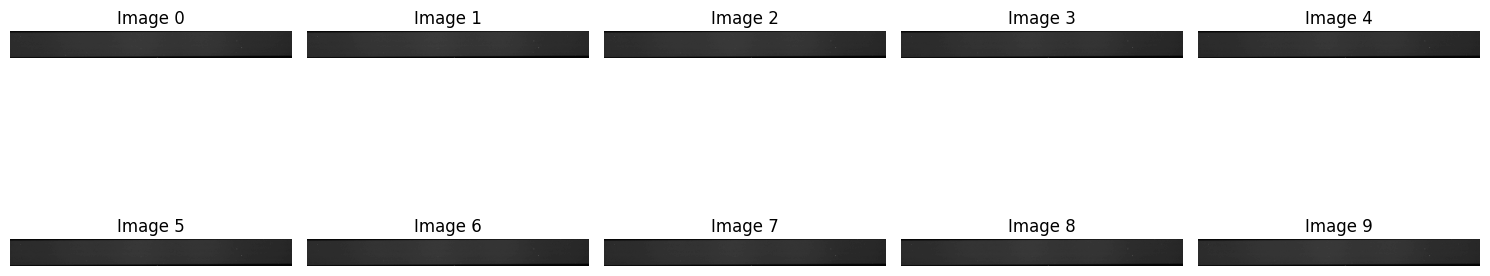

In [13]:
import matplotlib.pyplot as plt
from astropy.io import fits

# List of file paths
spec_flats = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000000.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000001.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000002.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000003.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000004.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000005.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000006.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000007.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000008.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000009.FLAT.FIT'
]

# Define the cropping coordinates
x_min, x_max = 0, 765
y_min, y_max = 30, 102

# Create a subplot grid to display all cropped images
n_files = len(spec_flats)
n_cols = 5
n_rows = (n_files + n_cols - 1) // n_cols  # Compute the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), squeeze=False)

# Display each cropped image
for idx, path in enumerate(spec_flats):
    with fits.open(path) as hdul:
        image_data = hdul[0].data

    # Crop the image
    cropped_image = image_data[y_min:y_max, x_min:x_max]

    ax = axes[idx // n_cols, idx % n_cols]
    cax = ax.imshow(cropped_image, cmap='gray', origin='lower')
    ax.set_title(f'Image {idx}')
    ax.axis('off')

# Hide any unused subplots
for j in range(idx + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis('off')

plt.tight_layout()
plt.show()

In [14]:
cut_spec_flats = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_00.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_01.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_02.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_03.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_04.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_05.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_06.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_07.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_08.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_09.FIT'
]

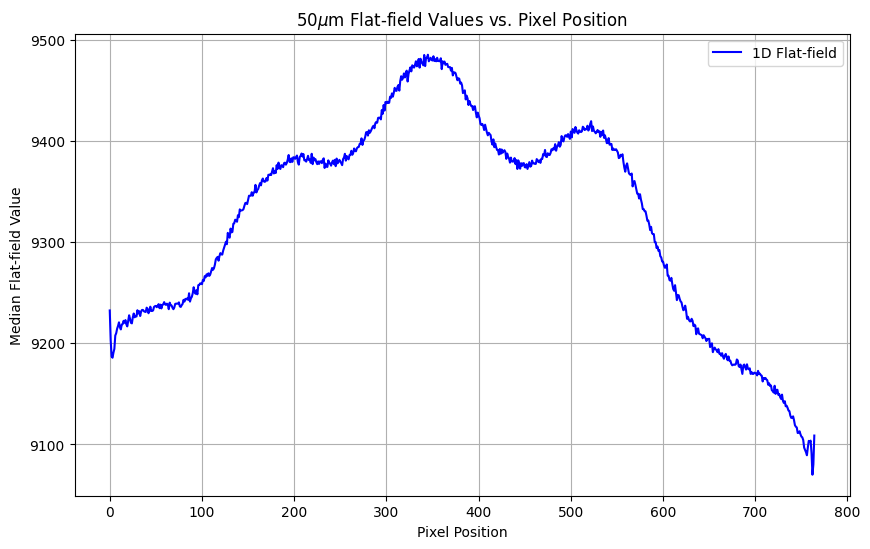

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# List of cropped image file paths
cut_spec_flats = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_00.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_01.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_02.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_03.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_04.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_05.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_06.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_07.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_08.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/cropped_image_09.FIT'
]

# Read in the FITS files and extract image data
data_list = []
for path in cut_spec_flats:
    with fits.open(path) as hdul:
        data_list.append(hdul[0].data)

# Convert list to a 3D numpy array
data_cube = np.array(data_list)

# Collapse the 3D data to 2D by taking the median across the first axis
flat_field_2d = np.median(data_cube, axis=0)

# Collapse the 2D flat-field data to 1D by taking the median of each column
median_flat_field = np.median(flat_field_2d, axis=0)

# Create an array of pixel positions (assuming the first dimension is along the dispersion axis)
pixel_positions = np.arange(len(median_flat_field))

# Plot the 1D flat-field values
plt.figure(figsize=(10, 6))
plt.plot(pixel_positions, median_flat_field, label='1D Flat-field', color='blue')
plt.xlabel('Pixel Position')
plt.ylabel('Median Flat-field Value')
plt.title('50$\mu$m Flat-field Values vs. Pixel Position')
plt.legend()
plt.grid(True)
plt.show()

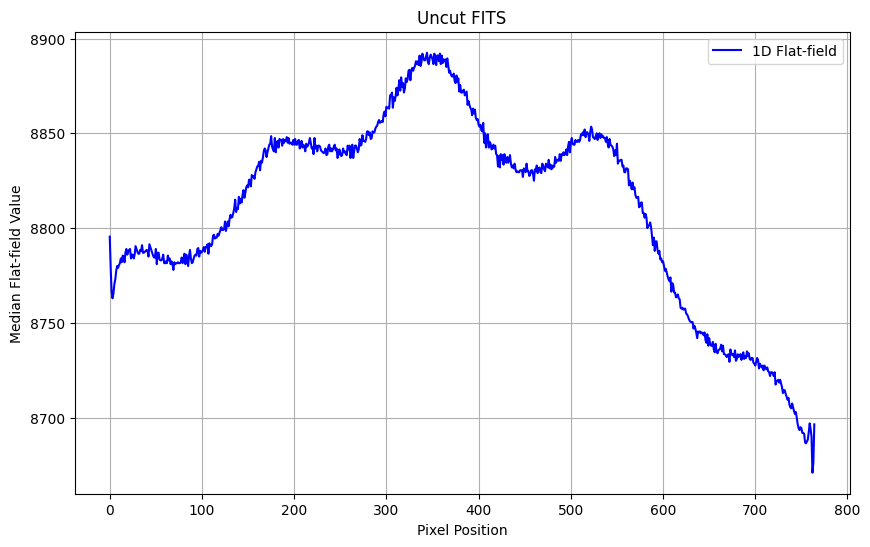

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the FITS files
spec_flats = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000000.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000001.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000002.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000003.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000004.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000005.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000006.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000007.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000008.FLAT.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/spectroscopy_flat_15s_.00000009.FLAT.FIT'
]

# Read in the FITS files and extract image data
data_list = []
for path in spec_flats:
    with fits.open(path) as hdul:
        data_list.append(hdul[0].data)

# Convert list to a 3D numpy array
data_cube = np.array(data_list)

# Collapse the 3D data to 2D by taking the median across the first axis
flat_field_1d = np.median(data_cube, axis=0)

# Collapse the 2D flat-field data to 1D by taking the median of each column
median_flat_field = np.median(flat_field_1d, axis=0)

# Create an array of pixel positions (assuming the first dimension is along the dispersion axis)
pixel_positions = np.arange(len(median_flat_field))

# Plot the 1D flat-field values
plt.figure(figsize=(10, 6))
plt.plot(pixel_positions, median_flat_field, label='1D Flat-field', color='blue')
plt.xlabel('Pixel Position')
plt.ylabel('Median Flat-field Value')
plt.title('Uncut FITS')
plt.legend()
plt.grid(True)
plt.show()


#4.4 3.

Normalized flat-field saved to /content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/normalized_spec_flat_field.FIT


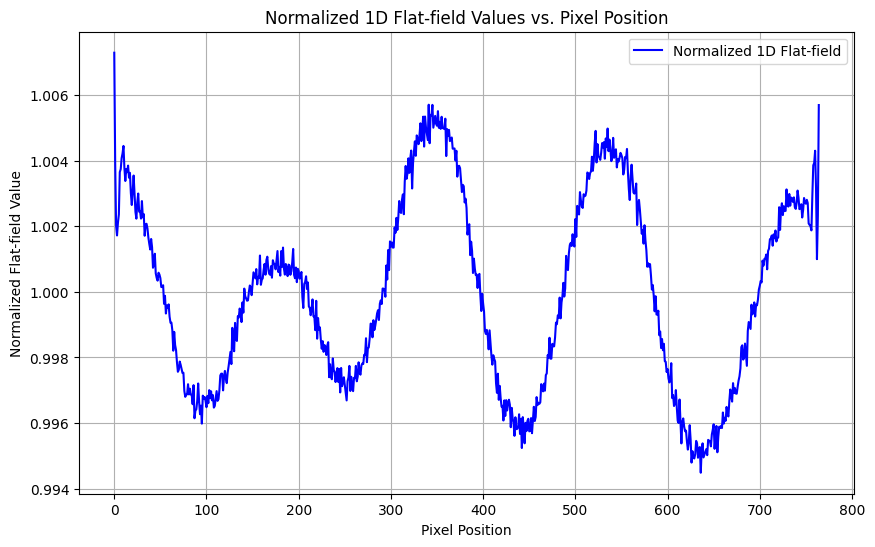

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import os

# Define a polynomial function for fitting
def poly_fit(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Read in the FITS files and extract image data
data_list = []
for path in cut_spec_flats:
    with fits.open(path) as hdul:
        data_list.append(hdul[0].data)

# Convert list to a 3D numpy array
data_cube = np.array(data_list)

# Collapse the 3D data to 2D by taking the median across the first axis
flat_field_2d = np.median(data_cube, axis=0)

# Collapse the 2D flat-field data to 1D by taking the median of each column
median_flat_field = np.median(flat_field_2d, axis=0)

# Create an array of pixel positions (assuming the first dimension is along the dispersion axis)
pixel_positions = np.arange(len(median_flat_field))

# Fit a low-order polynomial to the 1D flat-field spectrum
degree = 3  # You can change this degree if needed
coeffs, _ = curve_fit(lambda x, *coeffs: poly_fit(x, *coeffs), pixel_positions, median_flat_field, p0=np.ones(degree + 1))

# Generate the polynomial fit
poly_fit_values = poly_fit(pixel_positions, *coeffs)

# Normalize the 1D flat-field by dividing by the polynomial fit
normalized_flat_field = median_flat_field / poly_fit_values

# Normalize the 2D flat-field image
normalized_flat_field_2d = flat_field_2d / poly_fit_values

# Define the path for saving the normalized flat-field FITS file
normalized_fits_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_flats/normalized_spec_flat_field.FIT'

# Save the normalized 2D flat-field to a FITS file
hdu = fits.PrimaryHDU(normalized_flat_field_2d)
hdul = fits.HDUList([hdu])
hdul.writeto(normalized_fits_path, overwrite=True)

print(f'Normalized flat-field saved to {normalized_fits_path}')


# Plot the normalized 1D flat-field
plt.figure(figsize=(10, 6))
plt.plot(pixel_positions, normalized_flat_field, label='Normalized 1D Flat-field', color='blue')
plt.xlabel('Pixel Position')
plt.ylabel('Normalized Flat-field Value')
plt.title('Normalized 1D Flat-field Values vs. Pixel Position')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
spec_darks = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000000.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000001.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000002.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000003.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000004.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000005.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000006.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000007.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000008.DARK.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/spectroscopy_dark_15s_.00000009.DARK.FIT'
]

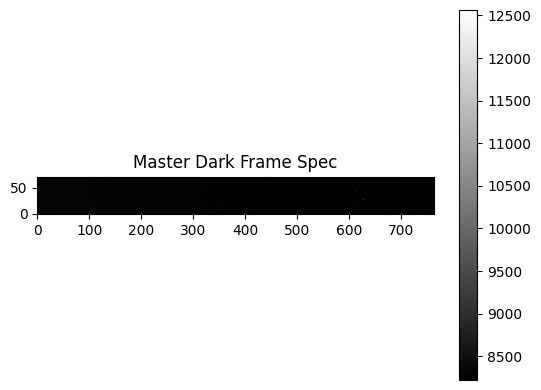

In [39]:
# Initialize a list to hold the data
dark_frames = []

# Define the cropping coordinates
x_min, x_max = 0, 765
y_min, y_max = 30, 102

# Load and crop each dark frame
for frame in spec_darks:
    with fits.open(frame) as hdul:
        # Assuming the image data is in the first HDU
        dark_frame = hdul[0].data
        # Crop the frame
        cropped_frame = dark_frame[y_min:y_max, x_min:x_max]
        dark_frames.append(cropped_frame)

# Convert to a numpy array and calculate the median across the stack
median_dark = np.median(dark_frames, axis=0)

# Create a new FITS file to save the master dark frame
hdu = fits.PrimaryHDU(median_dark)
hdu.writeto('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/master_dark_frame.FIT', overwrite=True)

# Optional: Display the median dark frame
plt.imshow(median_dark, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Master Dark Frame Spec')
plt.show()

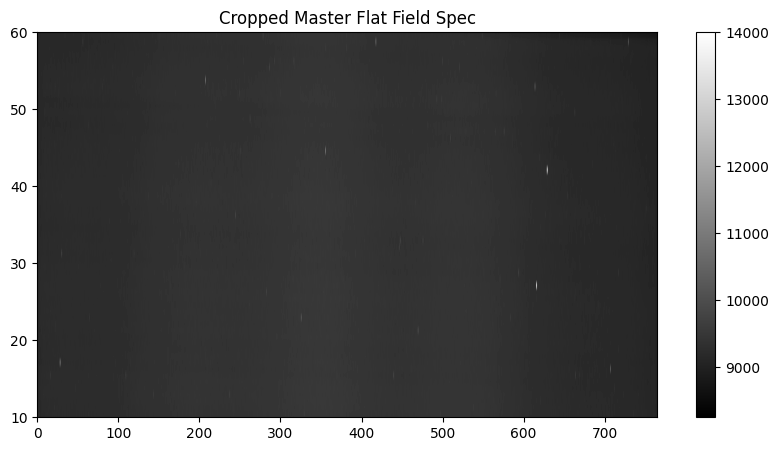

In [31]:
# Define a low-order polynomial function
def poly_func(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Initialize a list to store flat-fields
flats = []

for file_path in cut_spec_flats:
    # Read the FITS file
    with fits.open(file_path) as hdul:
        flat_data = hdul[0].data  # Assuming data is in the first HDU

    # Average over the vertical axis to create a 1D spectrum
    flat_1d = np.mean(flat_data, axis=0)

    # Fit a low-order polynomial (e.g., 3rd degree)
    x = np.arange(len(flat_1d))
    popt, _ = curve_fit(poly_func, x, flat_1d, p0=np.ones(4))  # p0 is initial guess for coefficients

    # Create fitted polynomial
    fit_curve = poly_func(x, *popt)

    # Create flat-field without normalization
    flat_field = flat_data  # Keep the original flat field
    flats.append(flat_field)

# Average the flat-fields to create the master flat field
master_flat_field = np.mean(flats, axis=0)

# Visualize the master flat field
plt.figure(figsize=(10, 5))
plt.title('Cropped Master Flat Field Spec')
plt.imshow(master_flat_field, aspect='auto', cmap='gray', extent=[0, master_flat_field.shape[1], 5, 65])
plt.colorbar()
plt.xlim(0, master_flat_field.shape[1])  # Adjust x-axis limits if necessary
plt.ylim(10, 60)  # Set y-axis limits to focus on the grey region

# Adjust the aspect ratio to ensure the region is shown more prominently
plt.gca().set_aspect('auto', adjustable='box')

plt.show()

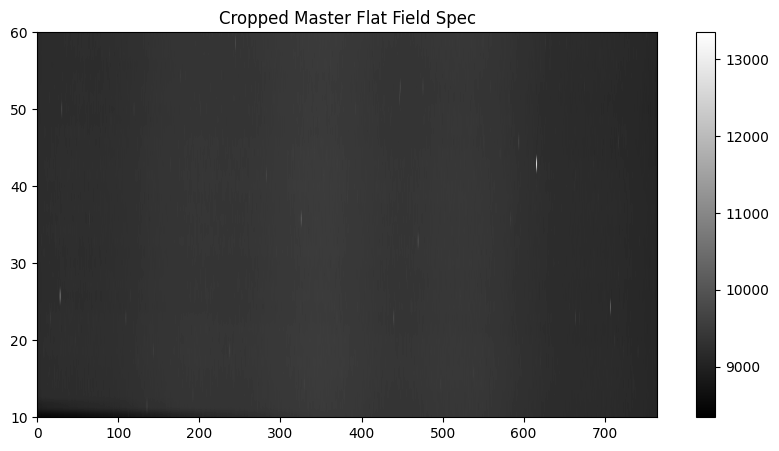

In [40]:
# Define a low-order polynomial function
def poly_func(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Initialize a list to store flat-fields
flats = []

# Define the cropping coordinates
x_min, x_max = 0, 765
y_min, y_max = 30, 102

for file_path in cut_spec_flats:
    # Read the FITS file
    with fits.open(file_path) as hdul:
        flat_data = hdul[0].data  # Assuming data is in the first HDU

    # Crop the flat data
    flat_data_cropped = flat_data[y_min:y_max, x_min:x_max]

    # Average over the vertical axis to create a 1D spectrum
    flat_1d = np.mean(flat_data_cropped, axis=0)

    # Fit a low-order polynomial (e.g., 3rd degree)
    x = np.arange(len(flat_1d))
    popt, _ = curve_fit(poly_func, x, flat_1d, p0=np.ones(4))  # p0 is initial guess for coefficients

    # Create fitted polynomial
    fit_curve = poly_func(x, *popt)

    # Create flat-field without normalization
    flat_field = flat_data_cropped  # Keep the cropped flat field
    flats.append(flat_field)

# Average the flat-fields to create the master flat field
master_flat_field = np.mean(flats, axis=0)

# Visualize the master flat field
plt.figure(figsize=(10, 5))
plt.title('Cropped Master Flat Field Spec')
plt.imshow(master_flat_field, aspect='auto', cmap='gray', extent=[0, master_flat_field.shape[1], 5, 65])
plt.colorbar()
plt.xlim(0, master_flat_field.shape[1])  # Adjust x-axis limits if necessary
plt.ylim(10, 60)  # Set y-axis limits to focus on the grey region

# Adjust the aspect ratio to ensure the region is shown more prominently
plt.gca().set_aspect('auto', adjustable='box')

plt.show()

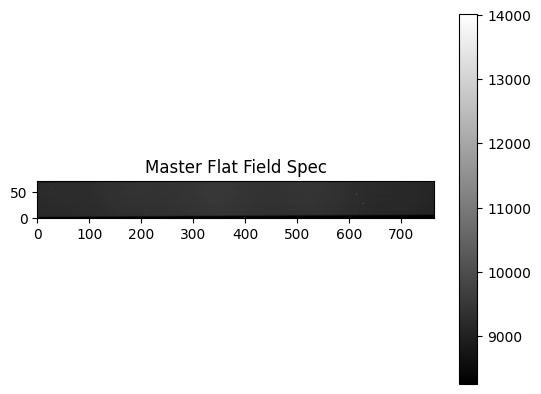

In [38]:
# Initialize a list to hold the data
flat_frames = []

# Define the cropping coordinates
x_min, x_max = 0, 765
y_min, y_max = 30, 102

# Load and crop each flat frame
for frame in spec_flats:
    with fits.open(frame) as hdul:
        # Assuming the image data is in the first HDU
        flat_frame = hdul[0].data
        # Crop the frame
        cropped_frame = flat_frame[y_min:y_max, x_min:x_max]
        flat_frames.append(cropped_frame)

# Convert to a numpy array and calculate the median across the stack
median_flat = np.median(flat_frames, axis=0)

# Create a new FITS file to save the master flat field
hdu = fits.PrimaryHDU(median_flat)
hdu.writeto('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/master_flat_field.FIT', overwrite=True)

# Optional: Display the median flat field
plt.imshow(median_flat, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Master Flat Field Spec')
plt.show()

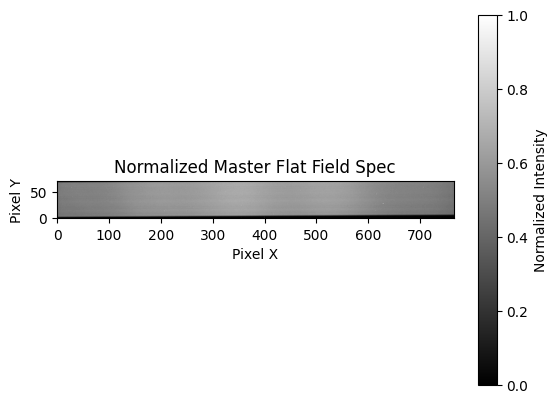

In [53]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

# Step 1: Read the FITS files
flat_field_data = fits.getdata('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/master_flat_field.FIT')
dark_frame_data = fits.getdata('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Dark/master_dark_frame.FIT')

# Step 2: Subtract the dark frame from the flat field
corrected_flat = flat_field_data - dark_frame_data

# Step 3: Normalize the result
min_val = np.min(corrected_flat)
max_val = np.max(corrected_flat)

# Normalize to the range 0 to 1
normalized_flat = (corrected_flat - min_val) / (max_val - min_val + 1e-10)

# Step 4: Save the normalized data as a FITS file
output_file_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/Normalized_Master_Flat_Field_Spec.FIT'
fits.writeto(output_file_path, normalized_flat, overwrite=True)

# Step 5: Display the normalized image
plt.imshow(normalized_flat, cmap='gray', origin='lower')
plt.colorbar(label='Normalized Intensity')
plt.title('Normalized Master Flat Field Spec')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

#4.3 4.

In [69]:
speclight_0= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000000.FIT')
speclight_1= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000001.FIT')
speclight_2= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000002.FIT')
speclight_3= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000003.FIT')
speclight_4= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000004.FIT')
speclight_5= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000005.FIT')
speclight_6= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000006.FIT')
speclight_7= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000007.FIT')
speclight_8= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000008.FIT')
speclight_9= fits.open('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000009.FIT')

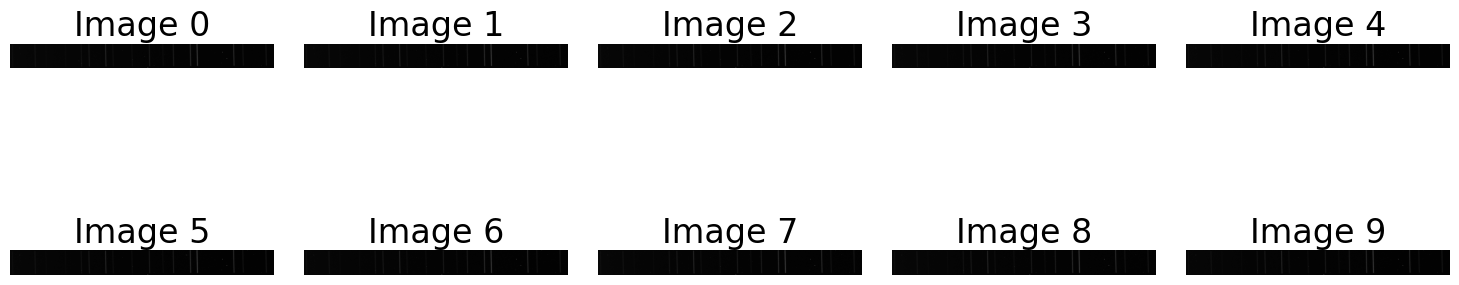

In [117]:
import matplotlib.pyplot as plt
from astropy.io import fits
import os

# List of file paths
spec_light = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000000.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000001.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000002.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000003.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000004.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000005.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000006.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000007.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000008.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/light/spectroscopy_light_15s_.00000009.FIT'
]

# Define the cropping coordinates
x_min, x_max = 0, 765
y_min, y_max = 30, 102

# Create output directory if it doesn't exist
output_dir = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights'
os.makedirs(output_dir, exist_ok=True)

# Create a subplot grid to display all cropped images
n_files = len(spec_light)
n_cols = 5
n_rows = (n_files + n_cols - 1) // n_cols  # Compute the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), squeeze=False)

# Display and save each cropped image
for idx, path in enumerate(spec_light):
    with fits.open(path) as hdul:
        image_data = hdul[0].data

    # Crop the image
    cropped_image = image_data[y_min:y_max, x_min:x_max]

    # Display the cropped image
    ax = axes[idx // n_cols, idx % n_cols]
    cax = ax.imshow(cropped_image, cmap='gray', origin='lower')
    ax.set_title(f'Image {idx}')
    ax.axis('off')

    # Save the cropped image as a FITS file
    hdu = fits.PrimaryHDU(cropped_image)
    output_fits_file = os.path.join(output_dir, f'cut_light_{idx}.FIT')
    hdu.writeto(output_fits_file, overwrite=True)

# Hide any unused subplots
for j in range(idx + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].axis('off')

plt.tight_layout()
plt.show()

In [54]:
cut_spec_light = [
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_0.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_1.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_2.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_3.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_4.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_5.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_6.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_7.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_8.FIT',
    '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_9.FIT'
]

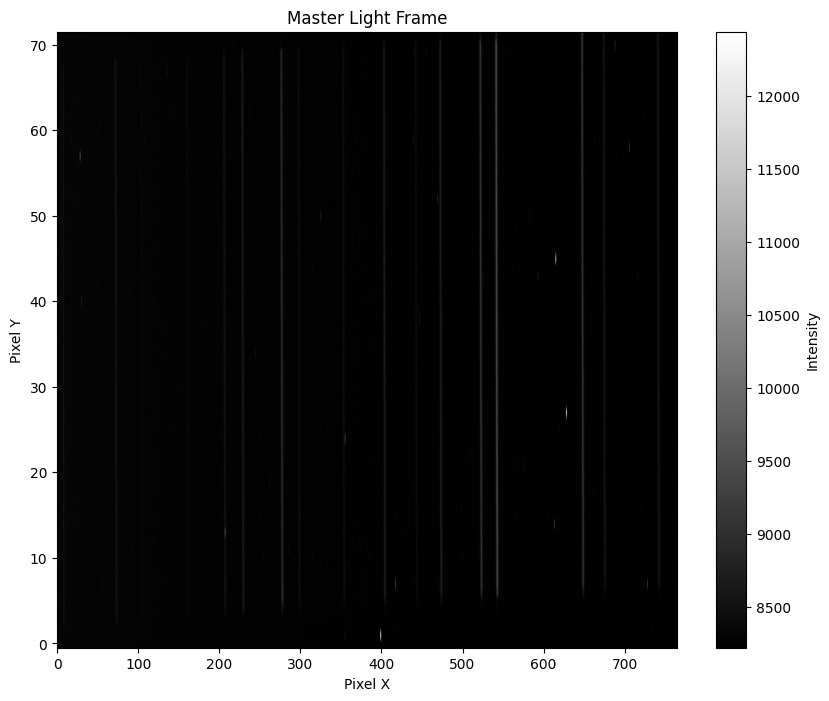

In [64]:
# Initialize a list to hold the data arrays
data_arrays = []

# Read each FIT file and extract the data
for file in cut_spec_light:
    with fits.open(file) as hdul:
        # Assuming the image data is in the first HDU
        data = hdul[0].data
        data_arrays.append(data)

# Stack the data arrays and compute the median
median_light_frame = np.median(np.array(data_arrays), axis=0)

# Create a new FITS file for the Master Light Frame
hdu = fits.PrimaryHDU(median_light_frame)
hdu.writeto('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Master_Light_Frame.FIT', overwrite=True)

# Display the Master Light Frame
plt.figure(figsize=(10, 8))
plt.imshow(median_light_frame, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('Master Light Frame')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

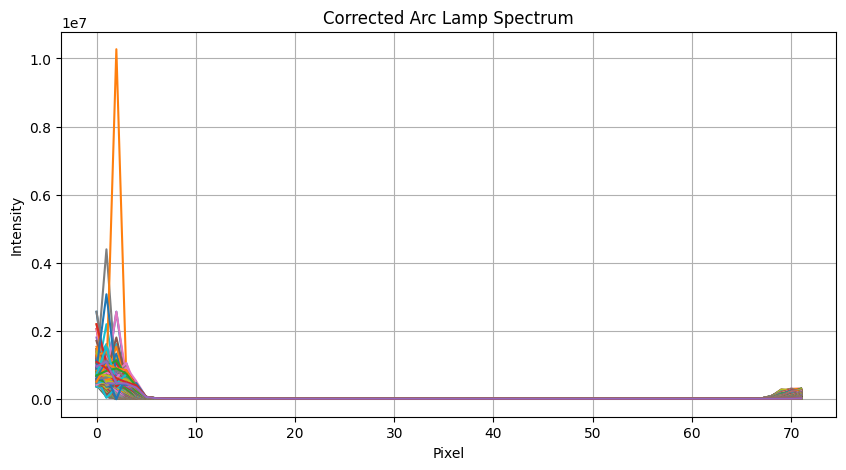

In [70]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# Load the normalized flat field and the raw arc lamp spectrum
flat_field_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/Normalized_Master_Flat_Field_Spec.FIT'
arc_lamp_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Master_Light_Frame.FIT'

# Read the FITS files
flat_field_data = fits.getdata(flat_field_path)
arc_lamp_data = fits.getdata(arc_lamp_path)

# Check if shapes match
if arc_lamp_data.shape != flat_field_data.shape:
    raise ValueError("The shapes of the flat field and arc lamp data do not match.")

# Replace zero values in the flat field to avoid division by zero
flat_field_data[flat_field_data == 0] = np.nan  # Use NaN to avoid division errors

# Apply the flat field correction
corrected_spectrum = arc_lamp_data / flat_field_data

# Handle NaNs by replacing them with zeros
corrected_spectrum = np.nan_to_num(corrected_spectrum, nan=0.0)

# Save the corrected spectrum to a new FITS file
#output_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Corrected_Arc_Lamp_Spectrum.FIT'
#hdu = fits.PrimaryHDU(corrected_spectrum)
#hdu.writeto(output_path, overwrite=True)

# Plot the corrected spectrum
plt.figure(figsize=(10, 5))
plt.plot(corrected_spectrum)
plt.title('Corrected Arc Lamp Spectrum')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.grid()
plt.show()

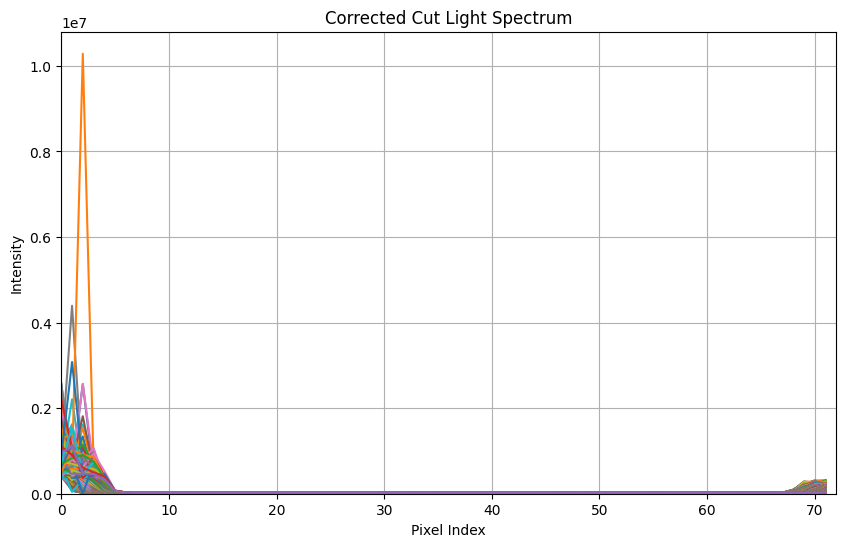

In [72]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# Load the normalized flat field spectrum
flat_field_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/Normalized_Master_Flat_Field_Spec.FIT'
flat_field_hdu = fits.open(flat_field_path)
normalized_flat_field = flat_field_hdu[0].data
flat_field_hdu.close()

# Load the cut light spectrum
cut_light_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_0.FIT'
cut_light_hdu = fits.open(cut_light_path)
cut_light_spectrum = cut_light_hdu[0].data
cut_light_hdu.close()

# Ensure both arrays have the same shape
if normalized_flat_field.shape != cut_light_spectrum.shape:
    raise ValueError("The shape of the normalized flat field and cut light spectrum must match.")

# Apply the normalized flat field by dividing the spectra
# Replace zeros in the normalized flat field to avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    corrected_spectrum = np.divide(cut_light_spectrum, normalized_flat_field, where=normalized_flat_field != 0)

# Handle any potential NaN values resulting from division by zero
corrected_spectrum = np.nan_to_num(corrected_spectrum)  # Replace NaNs with zeros

# Save the corrected spectrum to a new FITS file
#output_path = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/corrected_cut_light_0.FIT'
#hdu = fits.PrimaryHDU(corrected_spectrum)
#hdu.writeto(output_path, overwrite=True)

# Print the corrected spectrum
plt.figure(figsize=(10, 6))
plt.plot(corrected_spectrum)
plt.title('Corrected Cut Light Spectrum')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity')
plt.grid()
plt.xlim(0, len(corrected_spectrum))  # Adjust limits as necessary
plt.ylim(bottom=0)  # Start y-axis at 0 for better visualization
plt.show()

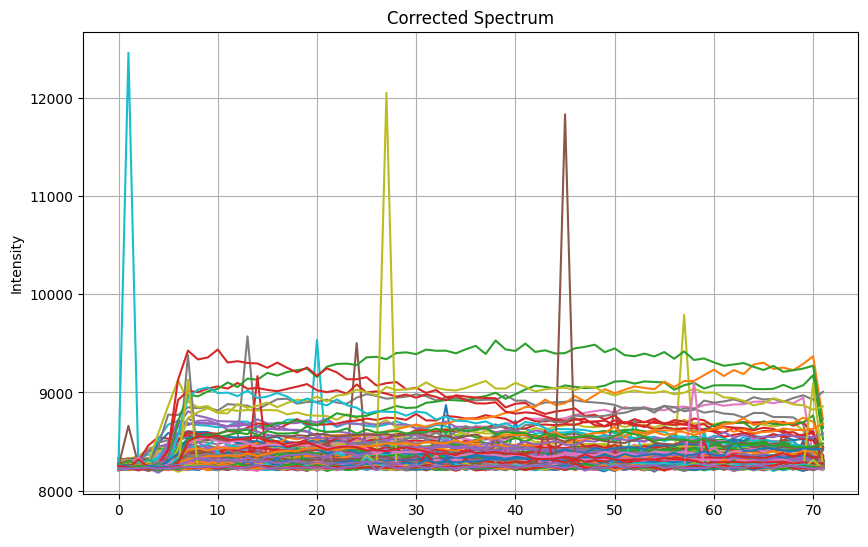

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the normalized flat field
flat_field_file = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/flat/Normalized_Master_Flat_Field_Spec.FIT'
with fits.open(flat_field_file) as hdul:
    flat_field_data = hdul[0].data  # Adjust the index if needed

# Load the cut light spectrum
cut_light_file = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Cut_lights/cut_light_0.FIT'
with fits.open(cut_light_file) as hdul:
    cut_light_data = hdul[0].data  # Adjust the index if needed

# Ensure both arrays are of the same shape
if flat_field_data.shape != cut_light_data.shape:
    raise ValueError("The flat field and cut light spectrum must have the same shape.")

# Add the normalized flat field to the cut light spectrum
corrected_spectrum = cut_light_data + flat_field_data

# Save the corrected spectrum to a new FITS file
hdu = fits.PrimaryHDU(corrected_spectrum)
hdu.writeto('/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Corrected_Spectrum.FIT', overwrite=True)

# Plotting the corrected spectrum
plt.figure(figsize=(10, 6))
plt.plot(corrected_spectrum)
plt.title('Corrected Spectrum')
plt.xlabel('Wavelength (or pixel number)')  # Adjust based on your data
plt.ylabel('Intensity')
plt.grid()
plt.show()

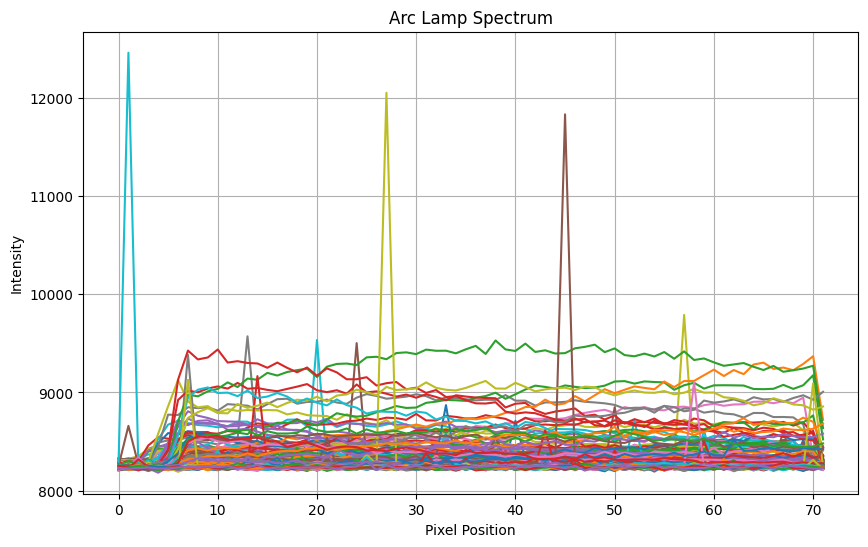

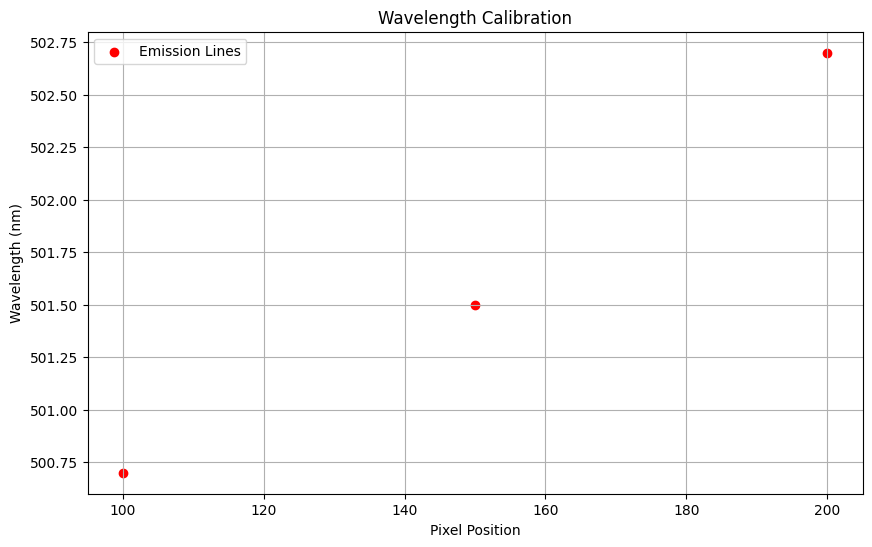

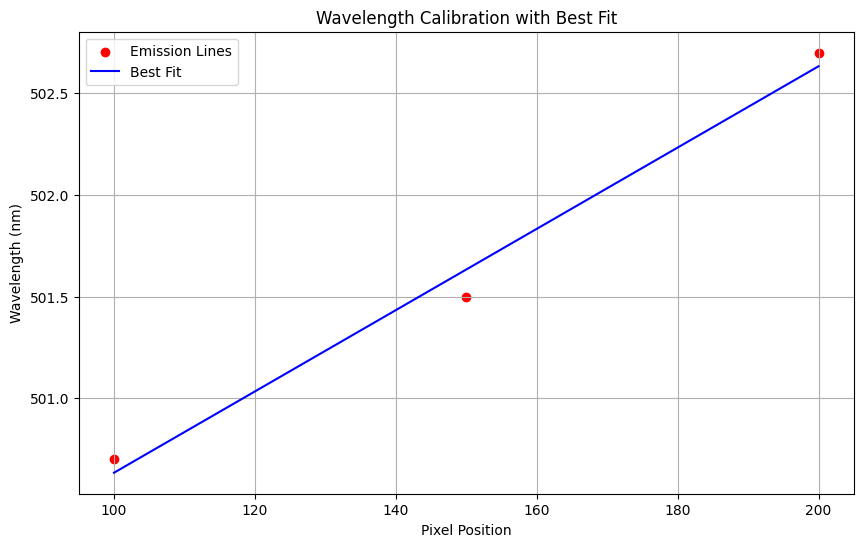

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Step 1: Load the Arc Lamp Spectrum
arc_lamp_file = '/content/drive/MyDrive/AST 443 Group 5/Lab 1 CCD/Group 5 data lab1/spectroscopy/Corrected_Spectrum.FIT'  # Update this path
with fits.open(arc_lamp_file) as hdul:
    arc_lamp_data = hdul[0].data  # Adjust if needed

# Step 2: Plot the arc lamp spectrum to visually identify emission lines
plt.figure(figsize=(10, 6))
plt.plot(arc_lamp_data)
plt.title('Arc Lamp Spectrum')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.grid()
plt.show()

# Step 3: Manually identify emission lines and create a table
# Example emission line data (pixel positions and known wavelengths)
# Update this data based on your findings
emission_lines = np.array([
    [100, 500.7],
    [150, 501.5],
    [200, 502.7],
    # Add more lines as needed
])

pixel_positions = emission_lines[:, 0]
wavelengths = emission_lines[:, 1]

# Step 4: Plot Wavelength vs. Pixel Position
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, wavelengths, color='red', label='Emission Lines')
plt.title('Wavelength Calibration')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (nm)')
plt.grid()
plt.legend()
plt.show()

# Step 5: Fit a Polynomial
coefficients = np.polyfit(pixel_positions, wavelengths, 1)  # Change degree if needed
polynomial = np.poly1d(coefficients)

# Generate fitted values for plotting
fit_positions = np.linspace(min(pixel_positions), max(pixel_positions), 100)
fit_wavelengths = polynomial(fit_positions)

# Step 6: Plot the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, wavelengths, color='red', label='Emission Lines')
plt.plot(fit_positions, fit_wavelengths, color='blue', label='Best Fit')
plt.title('Wavelength Calibration with Best Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (nm)')
plt.grid()
plt.legend()
plt.show()

# Step 7: Save the Calibration
#np.savetxt('wavelength_calibration.txt', coefficients)
#print("Wavelength calibration coefficients saved successfully.")

In [83]:
# Assuming wavelengths_cut contains the wavelengths from the calibration
min_wavelength = np.min(wavelengths_cut)
max_wavelength = np.max(wavelengths_cut)

# Length of the spectrum in Ångströms
length_of_spectrum = max_wavelength - min_wavelength

# Number of pixels in the spectrum
num_pixels = len(wavelengths_cut)

# Dispersion in Å/pixel
dispersion = length_of_spectrum / num_pixels

print(f"Length of the spectrum: {length_of_spectrum:.2f} Å")
print(f"Dispersion: {dispersion:.4f} Å/pixel")

Length of the spectrum: 5.08 Å
Dispersion: 0.0199 Å/pixel
